In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 10]

### Dati - u1_week_meteo.csv 

In [2]:
u1_w = pd.read_csv("./u1_week_meteo.csv")
u1_w = u1_w.set_index(pd.DatetimeIndex(u1_w["T"]))
u1_w = u1_w.drop(columns="T")
u1_w.tail()

consumi  temperature   humidity  is_raining  ore_luce
T                                                                  
2020-12-06  57.027679     3.460461  92.447321    0.397024       8.0
2020-12-13  52.162143     5.004780  97.379762    0.299702       8.0
2020-12-20  54.510893     6.563409  95.424702    0.160714       8.0
2020-12-27  55.963393     6.614393  92.863988    0.181548       8.0
2021-01-03  54.566875     0.874615  92.149479    0.023438       8.0

# Statsmodels

### Scomposizione serie

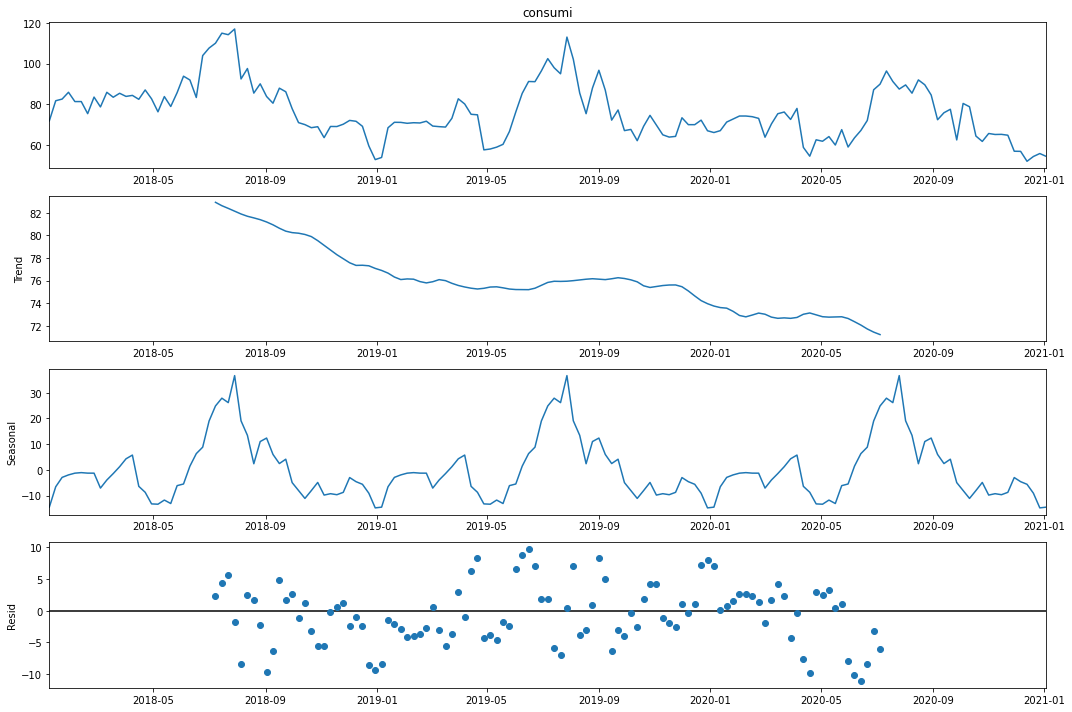

In [3]:
decomposed = seasonal_decompose(u1_w["consumi"], model="additive", period=52)
decomposed.plot();

### Verifica stazionarietà

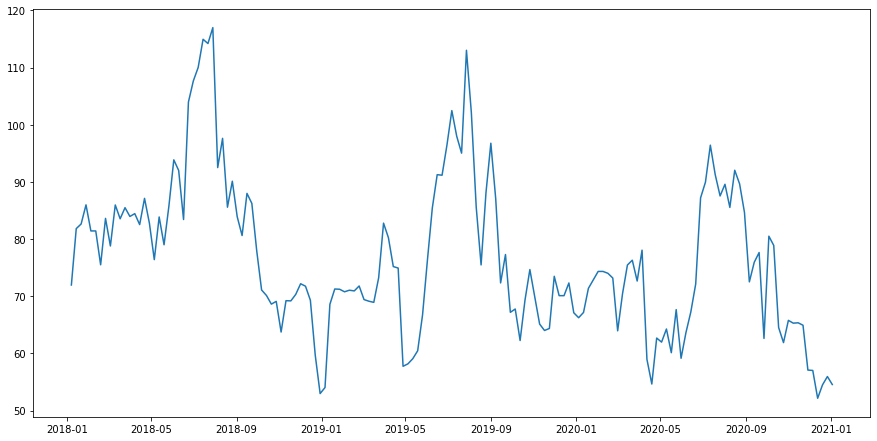

In [4]:
plt.rcParams["figure.figsize"] = [15, 7.5]

plt.plot(u1_w["consumi"])

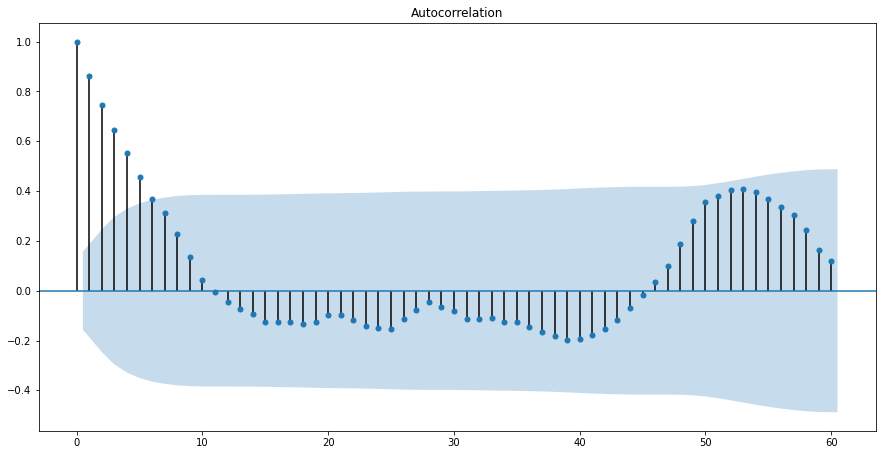

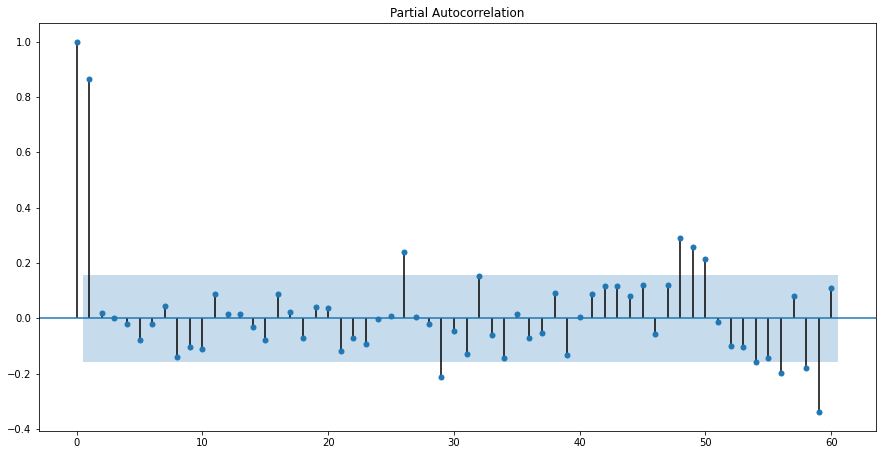

In [5]:
plot_acf(u1_w["consumi"],lags=60)
plot_pacf(u1_w["consumi"],lags=60);

In [6]:
adf = adfuller(u1_w["consumi"], autolag='AIC')

print("H0: La serie non è stazionaria\n")
alpha = 0.01

print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}\n")

if adf[1] > alpha:
    print("La serie non è stazionaria (non rifiuto H0)")
else:
    print("La serie è stazionaria (rifiuto H0)")

H0: La serie non è stazionaria

ADF Statistic: -3.096394518099265
p-value: 0.026821163437222913

La serie non è stazionaria (non rifiuto H0)


### Verifica stazionarietà serie differenziata lag=1

Serie non usata nelle previsioni \
Così la serie è stazionaria

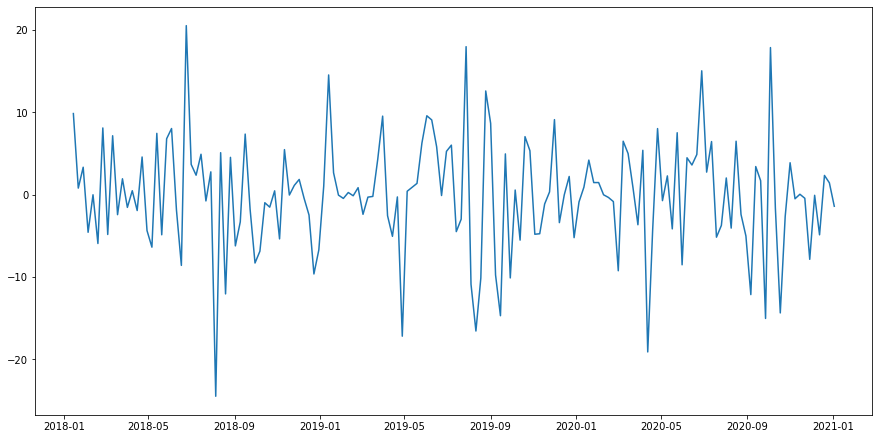

In [7]:
u1_w_diff = u1_w["consumi"].diff()
u1_w_diff = u1_w_diff.dropna() #primo valore sarebbe NaN per la differenziazione
plt.plot(u1_w_diff)

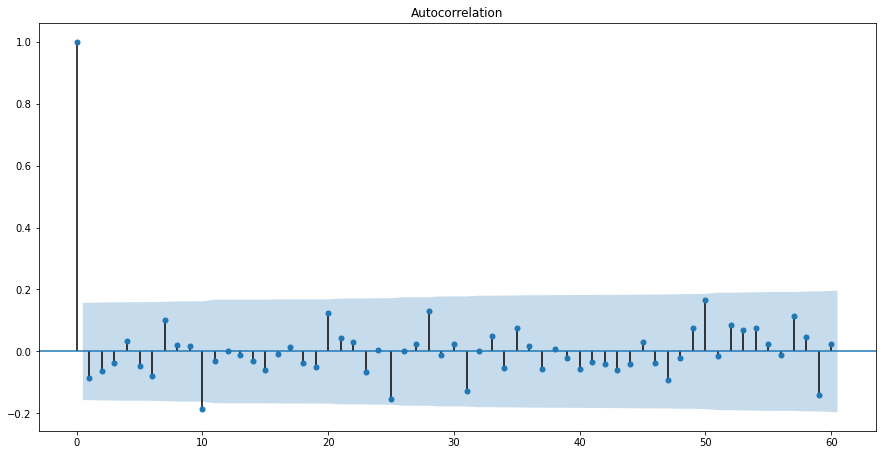

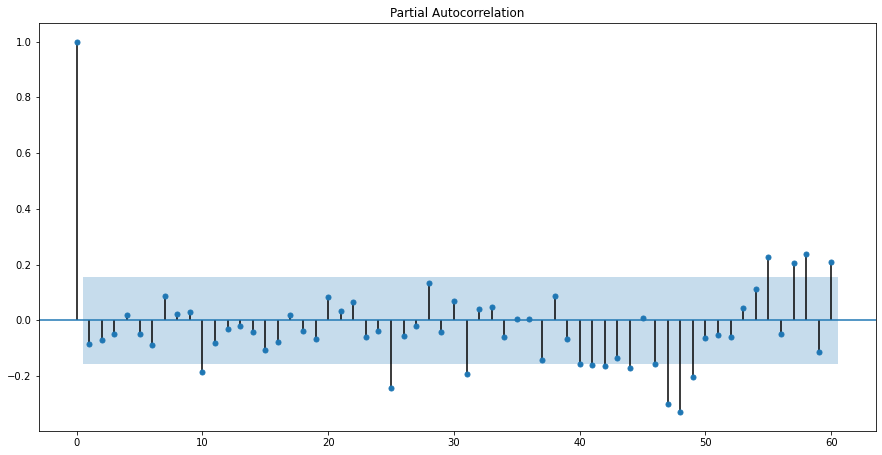

In [8]:
plot_acf(u1_w_diff,lags=60)
plot_pacf(u1_w_diff,lags=60);

In [9]:
adf_diff = adfuller(u1_w_diff, autolag='AIC')

print("H0: La serie non è stazionaria\n")
alpha = 0.01

print(f"ADF Statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}\n")

if adf_diff[1] > alpha:
    print("La serie non è stazionaria (non rifiuto H0)")
else:
    print("La serie è stazionaria (rifiuto H0)")

H0: La serie non è stazionaria

ADF Statistic: -13.548323157944427
p-value: 2.4369183854328726e-25

La serie è stazionaria (rifiuto H0)


# SARIMA e SARIMAX

### Funzioni

In [10]:
def optimize_SARIMAX(parameters_list, d, D, s, endog, exog = None):
    """
    Ritorna un dataframe con il set di parametri e il corrispondente AIC
    endog - variabile osservata 
    exog - variabile esogena, default = None per SARIMA
    parameters_list - lista di tuple (p, q, P, Q) 
    d - differenziazione
    D - differenziazione stagionale
    s - lunghezza della stagionalità
    """
    
    results = []
    
    for param in tqdm(parameters_list): 
        try:
            model = SARIMAX(endog,
                            exog,
                            order=(param[0], d, param[1]),
                            seasonal_order=(param[2], D, param[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ["(p,q)x(P,Q)", "AIC"]
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
def forecast(n_forecast, model, nome_modello, colore, exog=None):
    """
    Ritorna i grafici necessari per visualizzare la prvisione dei modelli
    """
    
    try:
        pred = model.get_prediction(end=model.nobs + n_forecast, exog=exog[-(n_forecast+1):])   
    except:
        pred = model.get_prediction(end=model.nobs + n_forecast)
        
    last_date = u1_w.index[u1_w.consumi == endog[model.nobs-1]].tolist()[0].strftime("%Y-%m-%d")
    
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.plot(u1_w["consumi"], color="dimgrey")
    plt.plot(pred.predicted_mean[1:], color=colore) #primo valore non valido

    plt.legend(["consumi (settimanale)", nome_modello])
    plt.title("Serie e previsione")
    plt.axvline(last_date, 0, 0.725, color="black")
    plt.text(last_date, 105, "Inizio previsione") 
    plt.show()

    if model.nobs <= 120:
        plt.rcParams["figure.figsize"] = [7, 7]
        pred_ci = pred.conf_int(alpha=0.1)
        upper = pred_ci["upper consumi"]
        lower = pred_ci["lower consumi"]

        plt.plot(pred.predicted_mean[-(n_forecast+1):], color=colore)
        if len(pred.predicted_mean)<len(u1_w["consumi"])+1:
            plt.plot(u1_w["consumi"][-(n_forecast+1):], color="dimgrey")
            plt.legend(["consumi (settimanale)", nome_modello])

        plt.fill_between(pred_ci.index[-(n_forecast+1):], 
                         upper[-(n_forecast+1):], 
                         lower[-(n_forecast+1):], 
                         alpha=0.15, color=colore)

        plt.title("Focus previsione con intervallo di confidenza")
        plt.show()
        
    return pred

In [12]:
def mape(model, pred, cut=None):
    """
    Calcolo del MAPE
    """
    
    if cut and cut > 0:
        mape_tmp = np.mean(np.abs(endog[:cut] - pred.predicted_mean[:cut]) / np.abs(endog[:cut]))
    elif cut:
        mape_tmp = np.mean(np.abs(endog[cut:] - pred.predicted_mean[cut:]) / np.abs(endog[cut:]))
    else:
        mape_tmp = np.mean(np.abs(endog - pred.predicted_mean) / np.abs(endog))

    mape = f"MAPE: {round(mape_tmp * 100, 2)}%"

    return mape

In [13]:
def plot_exog(exog, ylabel, colore):
    plt.rcParams["figure.figsize"] = [15, 3]

    fig, ax = plt.subplots()
    axes = [ax, ax.twinx()]
    axes[0].plot(decomposed.seasonal, color='dimgrey')
    axes[0].set_ylabel('Componente stagionale di consumi')
    axes[1].plot(exog, color=colore)
    axes[1].set_ylabel(ylabel)
    axes[1].set_title('Andamento consumi e variabile esogena a confronto')
    axes[1].tick_params(axis='x',labelrotation=50)
    
    plt.show()
    
    plt.rcParams["figure.figsize"] = [15, 10]

In [14]:
p = range(0, 4)
d = 1
q = range(0, 3)
P = range(0, 2)
D = 1
Q = range(0, 2)
s = 52

endog = u1_w["consumi"]
exog_t = u1_w["temperature"]
exog_h = u1_w["humidity"]
exog_r = u1_w["is_raining"] 
exog_l = u1_w["ore_luce"]

parameters_list = list(product(p, q, P, Q))

## SARIMA (D=1):

### Best model

In [15]:
best_param_sarima120 = optimize_SARIMAX(parameters_list, d, D, s, endog[:120])
best_param_sarima120[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 1, 0)  465.286371
1  (0, 2, 0, 1)  465.310299
2  (2, 1, 1, 0)  465.926206
3  (2, 1, 0, 1)  465.973222
4  (0, 2, 0, 0)  465.981629

endog = consumi p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [16]:
bm_sarima120 = SARIMAX(endog[:120],
                    order=(0,1,2), # p d q
                    seasonal_order=(1,1,0,52), # P D Q s
                    simple_differencing=False).fit(disp=False)

bm_sarima120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -228.643
Date:                             Thu, 11 Nov 2021   AIC                            465.286
Time:                                     15:40:36   BIC                            474.105
Sample:                                 01-07-2018   HQIC                           468.776
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3890      0.115     -3.378      0.001      -0.615      -0.163
ma.L2         -0.3768      0.120     -3.153      0.002      -0.611      -0.143
ar.S.L52      -0.5340      0.225     -2.373      0.018      -0.975      -0.093
sigma2        41.0539     12.025      3.414      0.001      17.485      64.623
===================================================================================
Ljung-Box (Q):                       55.22   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.06   Prob(JB):                         0.87
Heteroskedasticity (H):               1.51   Skew:                            -0.11
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

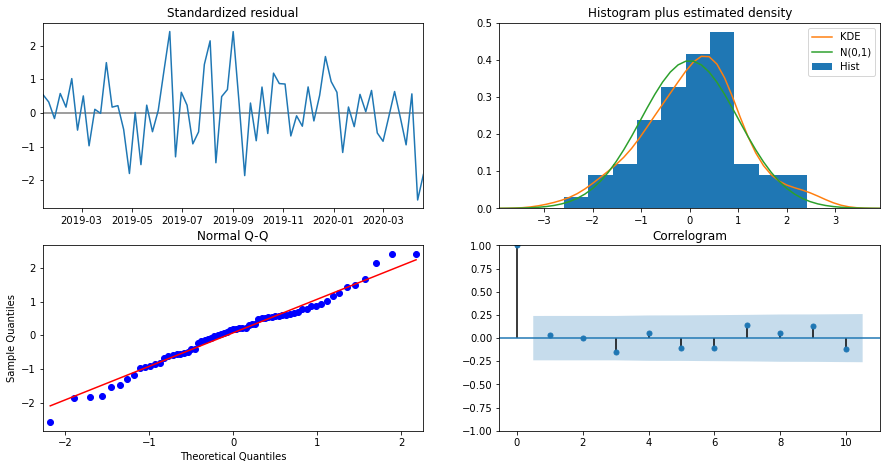

In [17]:
bm_sarima120.plot_diagnostics();

endog = consumi p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [18]:
best_param_sarima = optimize_SARIMAX(parameters_list, d, D, s, endog)
best_param_sarima[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 0, 1)  728.196021
1  (0, 2, 1, 0)  728.224601
2  (2, 2, 0, 1)  728.793244
3  (2, 2, 1, 0)  728.819762
4  (2, 1, 0, 1)  728.850582

Abbiamo scelto di utilizzare il secondo migliore AIC per avere gli stessi parametri del modello SARIMA120 precedente, infatti la differenza tra i primi due risultati in questo secondo modello è irrisoria.

In [19]:
bm_sarima = SARIMAX(endog,
                    order=(0,1,2), # p d q
                    seasonal_order=(1,1,0,52), # P D Q s
                    simple_differencing=False).fit(disp=False)

bm_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -360.112
Date:                             Thu, 11 Nov 2021   AIC                            728.225
Time:                                     15:44:30   BIC                            738.802
Sample:                                 01-07-2018   HQIC                           732.510
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3971      0.108     -3.678      0.000      -0.609      -0.185
ma.L2         -0.3692      0.117     -3.164      0.002      -0.598      -0.140
ar.S.L52      -0.4673      0.116     -4.017      0.000      -0.695      -0.239
sigma2        52.2751      6.104      8.564      0.000      40.311      64.239
===================================================================================
Ljung-Box (Q):                       42.70   Jarque-Bera (JB):                 4.78
Prob(Q):                              0.36   Prob(JB):                         0.09
Heteroskedasticity (H):               1.41   Skew:                             0.27
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

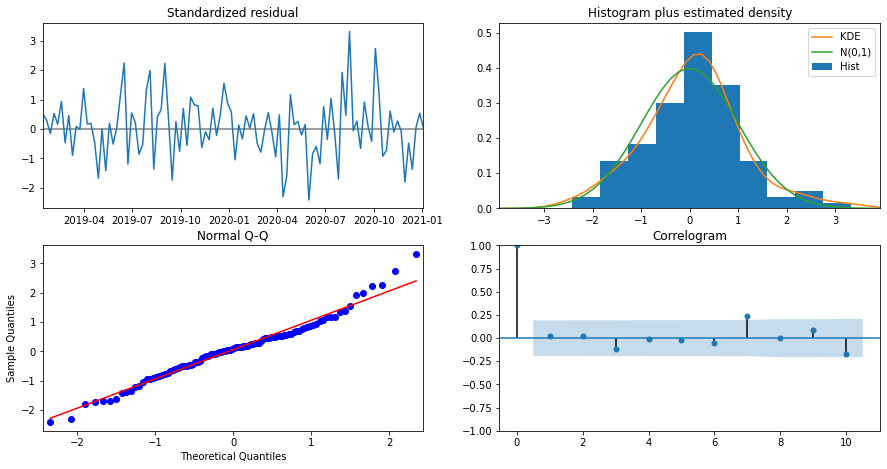

In [20]:
bm_sarima.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

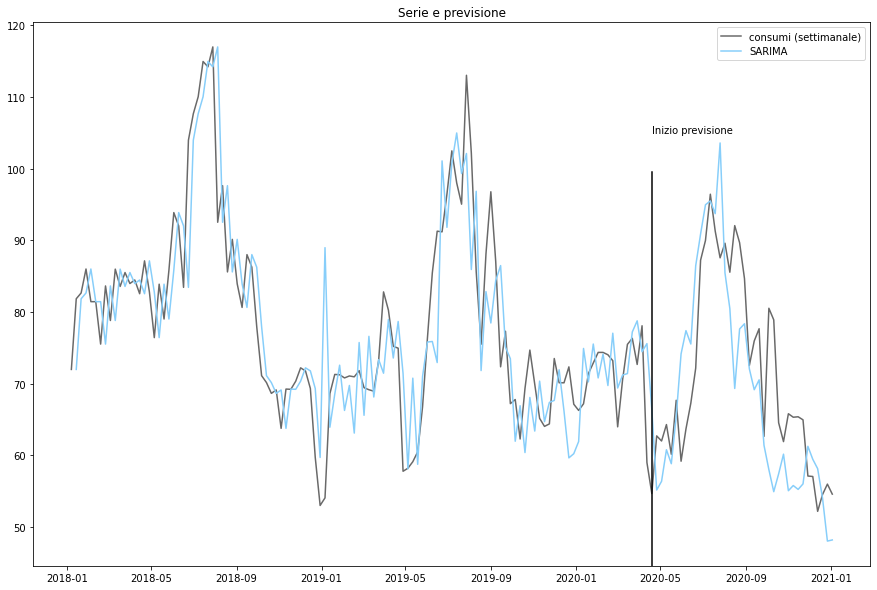

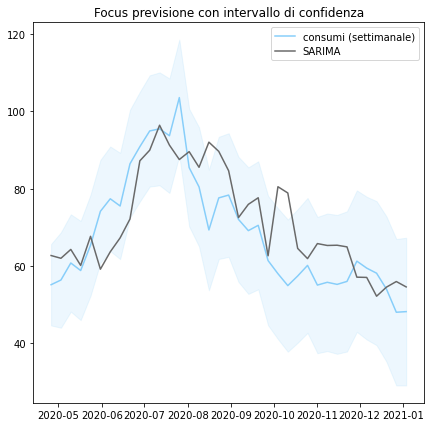

In [21]:
sarima120 = forecast(36, bm_sarima120, "SARIMA", "lightskyblue")

Previsione a 3 mesi

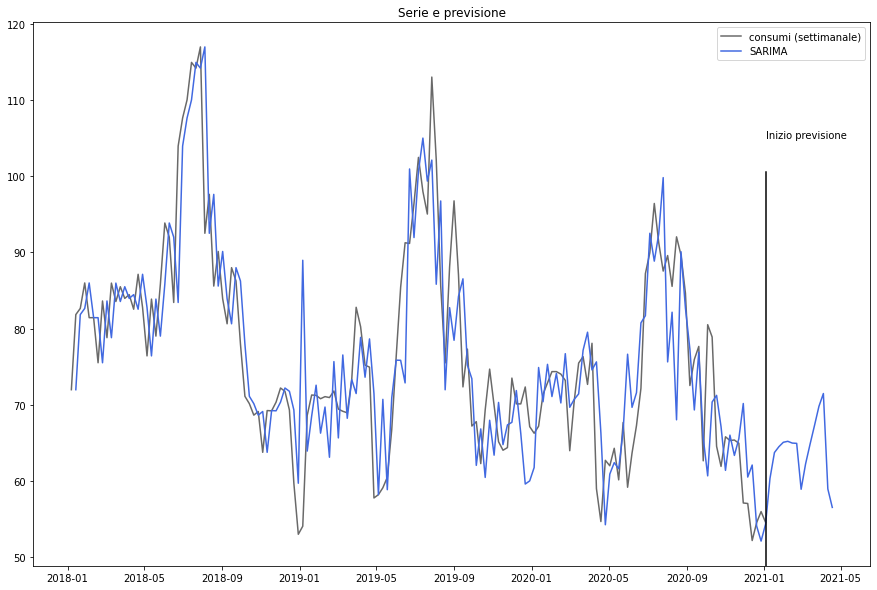

In [22]:
sarima = forecast(14, bm_sarima, "SARIMA", "royalblue")

Previsione a 6 mesi

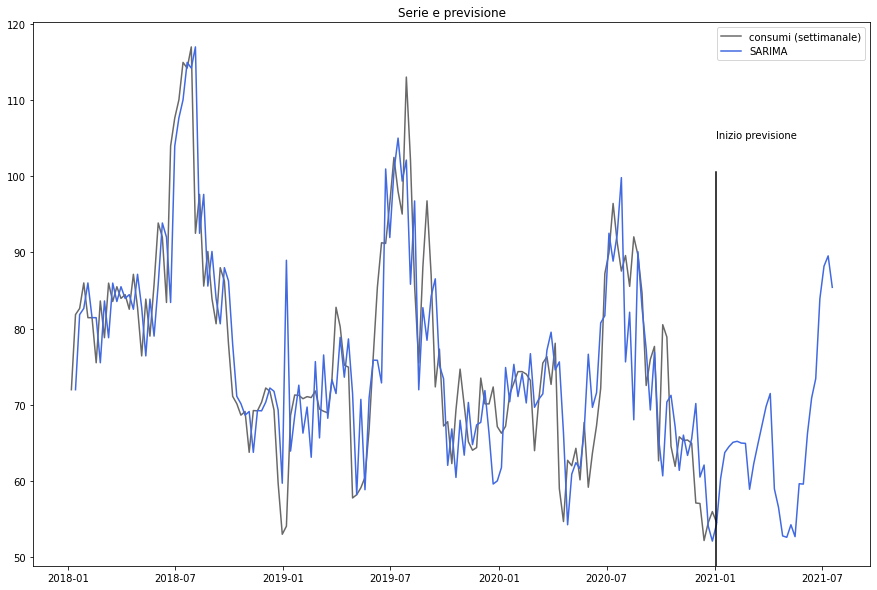

In [23]:
sarima = forecast(27, bm_sarima, "SARIMA", "royalblue")

Previsione a 9 mesi

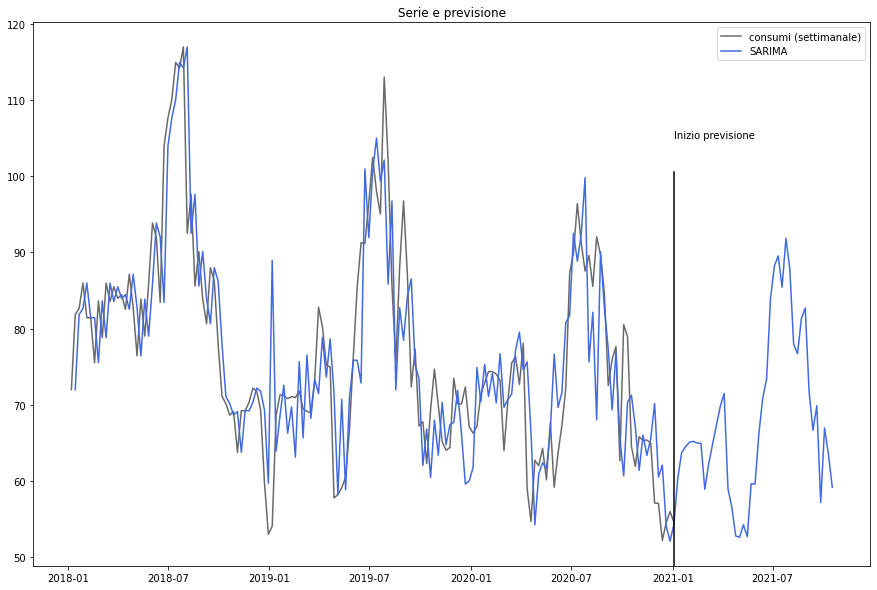

In [24]:
sarima = forecast(40, bm_sarima, "SARIMA", "royalblue")

### Verifica bontà del modello previsionale - MAPE

MAPE overall (157 osservazioni)

In [25]:
mape(endog, sarima)

'MAPE: 8.24%'

MAPE training set (prime 120 osservazioni)

In [26]:
mape(endog, sarima120, 120)

'MAPE: 8.27%'

MAPE test set (ultime 37 osservazioni)

In [27]:
mape(endog, sarima120, -37)

'MAPE: 10.87%'

## SARIMA (D=0):

### Best model

In [28]:
best_param_sarima120 = optimize_SARIMAX(parameters_list, d, 0, s, endog[:120])
best_param_sarima120[:5]

(p,q)x(P,Q)         AIC
0  (1, 1, 1, 0)  796.328448
1  (1, 1, 0, 1)  796.566769
2  (1, 1, 1, 1)  798.105208
3  (1, 2, 1, 0)  798.326427
4  (2, 1, 1, 0)  798.326658

endog = consumi p = 1 d = 1 q = 1 P = 1 D = 0 Q = 0 s = 52

In [29]:
bm_sarimad120 = SARIMAX(endog[:120],
                    order=(1,1,1), # p d q
                    seasonal_order=(1,0,0,52), # P D Q s
                    simple_differencing=False).fit(disp=False)

bm_sarimad120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood                -394.164
Date:                             Thu, 11 Nov 2021   AIC                            796.328
Time:                                     15:45:31   BIC                            807.445
Sample:                                 01-07-2018   HQIC                           800.843
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8458      0.064     13.268      0.000       0.721       0.971
ma.L1         -0.9821      0.040    -24.787      0.000      -1.060      -0.904
ar.S.L52       0.3178      0.129      2.460      0.014       0.065       0.571
sigma2        41.8330      5.199      8.046      0.000      31.643      52.024
===================================================================================
Ljung-Box (Q):                       36.91   Jarque-Bera (JB):                 5.61
Prob(Q):                              0.61   Prob(JB):                         0.06
Heteroskedasticity (H):               1.12   Skew:                            -0.10
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

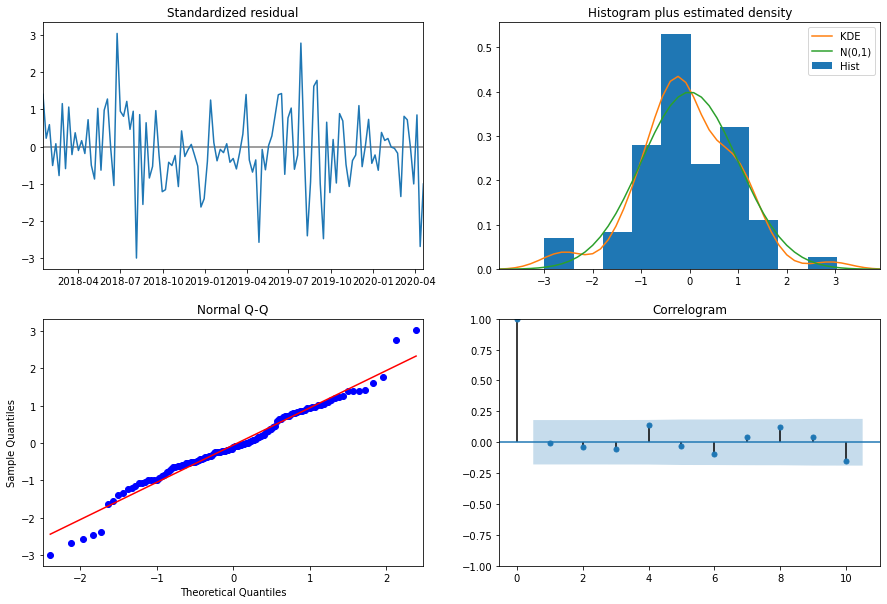

In [30]:
bm_sarimad120.plot_diagnostics();

In [31]:
best_param_sarima = optimize_SARIMAX(parameters_list, d, 0, s, endog)
best_param_sarima[:5]

(p,q)x(P,Q)          AIC
0  (1, 1, 1, 0)  1044.119346
1  (1, 1, 0, 1)  1044.444371
2  (1, 1, 0, 0)  1045.200982
3  (1, 1, 1, 1)  1045.421988
4  (1, 2, 1, 0)  1046.034871

endog = consumi p = 1 d = 1 q = 1 P = 1 D = 0 Q = 0 s = 52

In [32]:
bm_sarimad = SARIMAX(endog,
                    order=(1,1,1), # p d q
                    seasonal_order=(1,0,0,52), # P D Q s
                    simple_differencing=False).fit(disp=False)

bm_sarimad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood                -518.060
Date:                             Thu, 11 Nov 2021   AIC                           1044.119
Time:                                     15:46:31   BIC                           1056.319
Sample:                                 01-07-2018   HQIC                          1049.074
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8494      0.057     14.843      0.000       0.737       0.962
ma.L1         -0.9843      0.036    -27.016      0.000      -1.056      -0.913
ar.S.L52       0.1750      0.100      1.745      0.081      -0.022       0.372
sigma2        44.1403      4.523      9.759      0.000      35.275      53.006
===================================================================================
Ljung-Box (Q):                       32.24   Jarque-Bera (JB):                 5.05
Prob(Q):                              0.80   Prob(JB):                         0.08
Heteroskedasticity (H):               0.99   Skew:                            -0.00
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

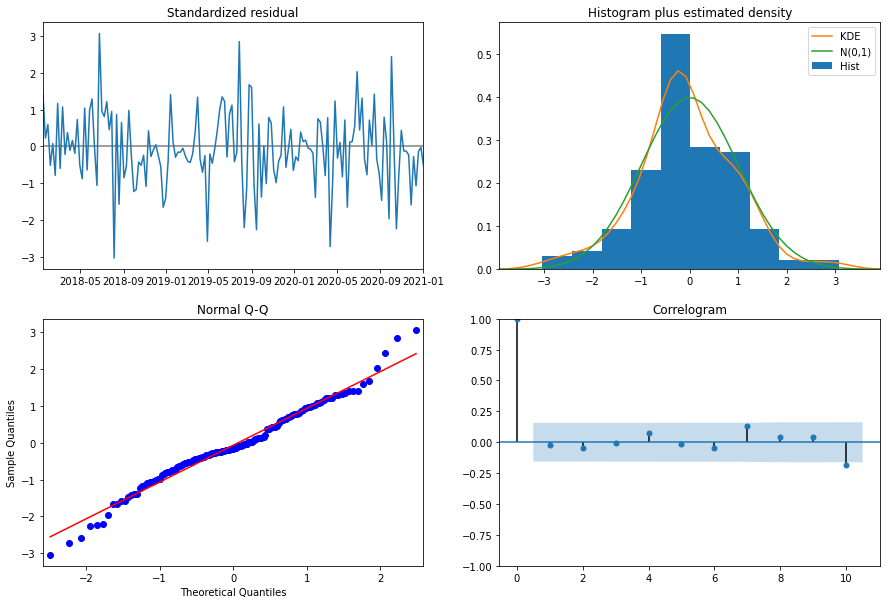

In [33]:
bm_sarimad.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

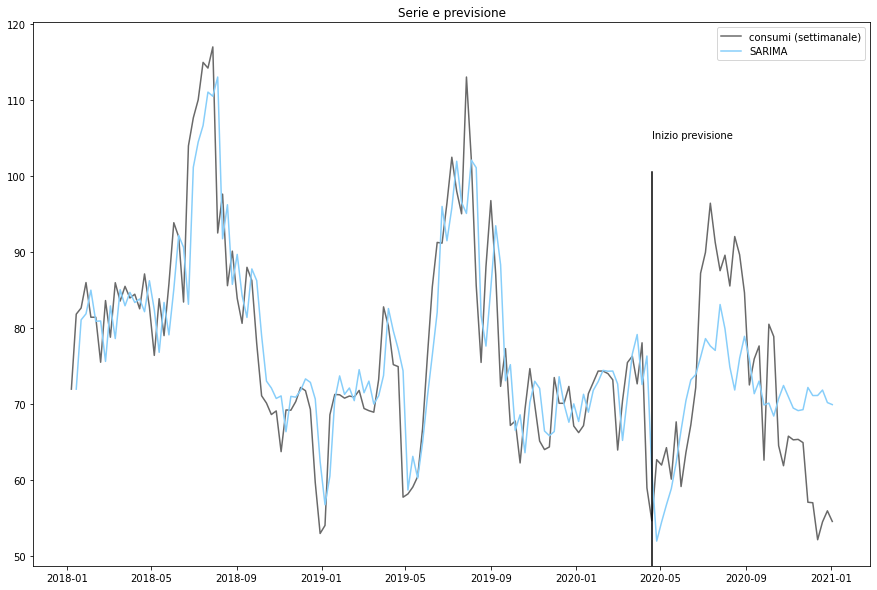

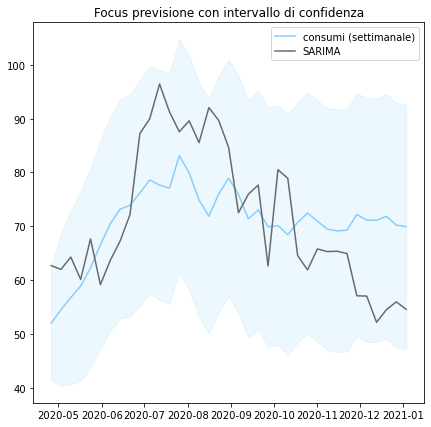

In [34]:
sarimad120 = forecast(36, bm_sarimad120, "SARIMA", "lightskyblue")

Previsione a 3 mesi

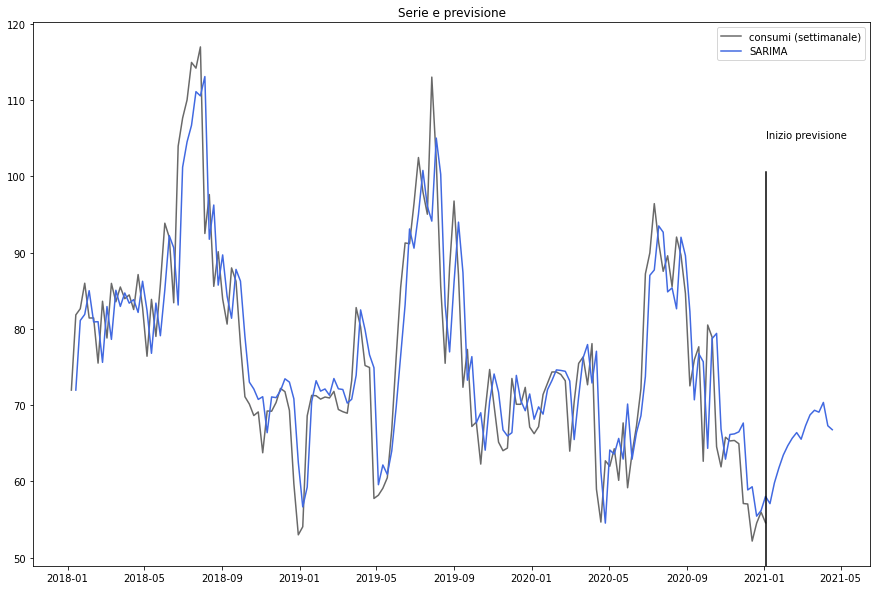

In [35]:
sarimad = forecast(14, bm_sarimad, "SARIMA", "royalblue")

Previsione a 6 mesi

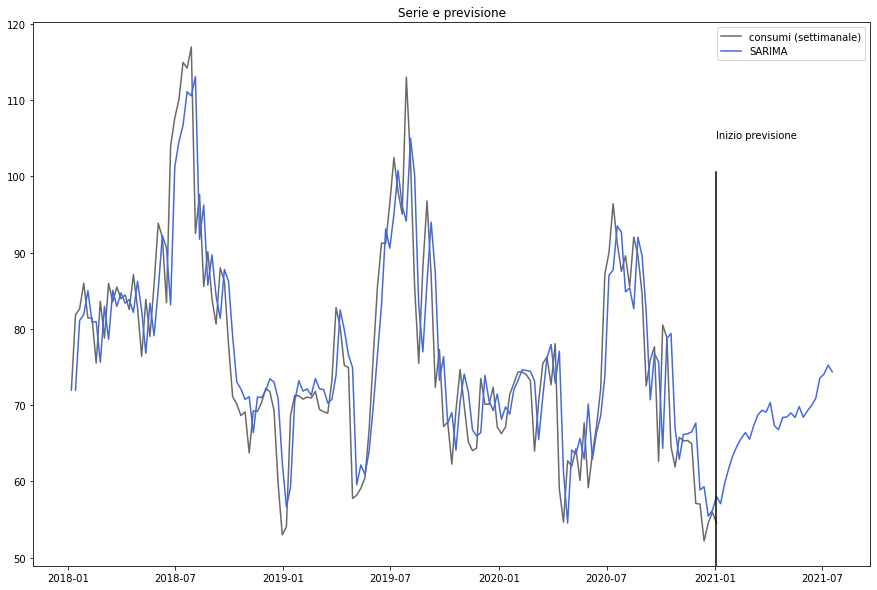

In [36]:
sarimad = forecast(27, bm_sarimad, "SARIMA", "royalblue")

Previsione a 9 mesi

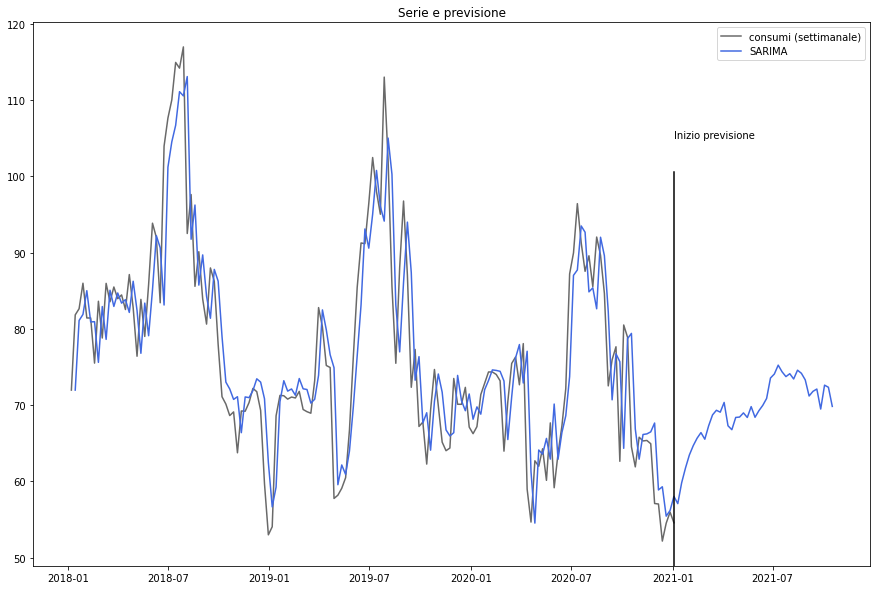

In [37]:
sarimad = forecast(40, bm_sarimad, "SARIMA", "royalblue")

### Verifica bontà del modello previsionale - MAPE

MAPE overall (157 osservazioni)

In [38]:
mape(endog, sarimad)

'MAPE: 7.27%'

MAPE training set (prime 120 osservazioni)

In [39]:
mape(endog, sarimad120, 120)

'MAPE: 7.26%'

MAPE test set (ultime 37 osservazioni)

In [40]:
mape(endog, sarimad120, -37)

'MAPE: 13.48%'

## SARIMAX temperatura:
    endog = consumi
    exog_t = temperature

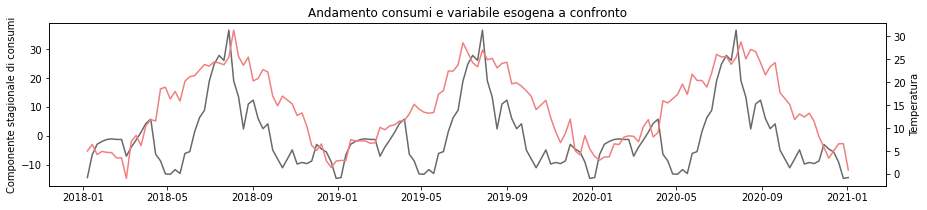

In [41]:
plot_exog(exog_t, "Temperatura", "lightcoral")

### Best model

In [42]:
best_param_sarimax_t120 = optimize_SARIMAX(parameters_list, d, D, s, endog[:120], exog_t[:120])
best_param_sarimax_t120[:5]

(p,q)x(P,Q)         AIC
0  (2, 2, 1, 0)  459.122956
1  (0, 2, 1, 0)  464.222380
2  (0, 2, 0, 1)  464.243795
3  (0, 2, 0, 0)  464.956204
4  (2, 1, 1, 0)  465.190316

p = 2 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [43]:
bm_sarimax_t120 = SARIMAX(endog[:120],
                          exog_t[:120],
                          order=(2,1,2), # p d q
                          seasonal_order=(1,1,0,52), # P D Q s
                          simple_differencing=False).fit(disp=False)

bm_sarimax_t120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 52)   Log Likelihood                -222.561
Date:                             Thu, 11 Nov 2021   AIC                            459.123
Time:                                     15:49:48   BIC                            474.556
Sample:                                 01-07-2018   HQIC                           465.230
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.6579      0.225      2.918      0.004       0.216       1.100
ar.L1           1.2836      0.100     12.811      0.000       1.087       1.480
ar.L2          -0.6724      0.082     -8.249      0.000      -0.832      -0.513
ma.L1          -1.8212      1.946     -0.936      0.349      -5.635       1.992
ma.L2           0.9987      2.129      0.469      0.639      -3.175       5.172
ar.S.L52       -0.5528      0.221     -2.498      0.013      -0.987      -0.119
sigma2         31.6169     67.940      0.465      0.642    -101.543     164.777
===================================================================================
Ljung-Box (Q):                       50.22   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.13   Prob(JB):                         0.32
Heteroskedasticity (H):               1.74   Skew:                            -0.14
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

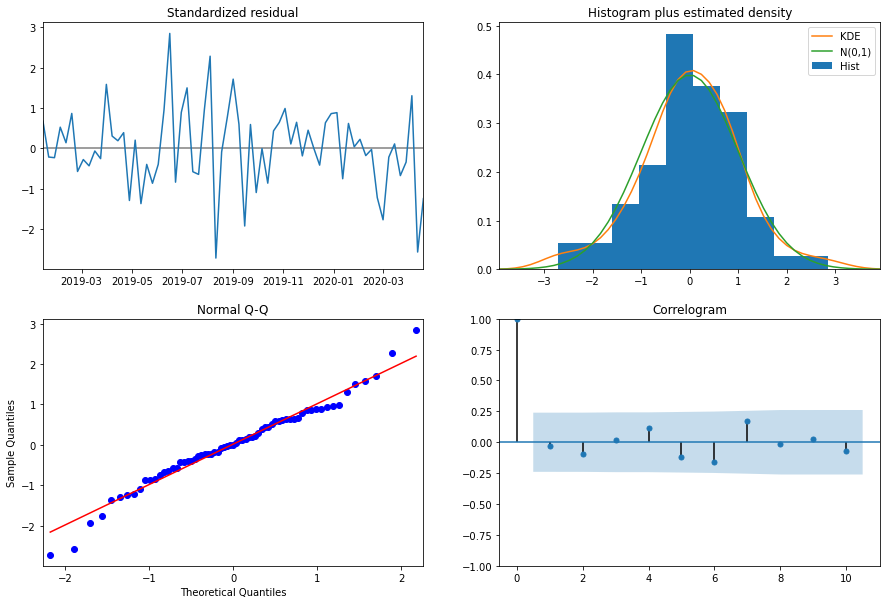

In [44]:
bm_sarimax_t120.plot_diagnostics();

In [45]:
best_param_sarimax_t = optimize_SARIMAX(parameters_list, d, D, s, endog, exog_t)
best_param_sarimax_t[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 1, 0)  720.669217
1  (0, 2, 0, 1)  720.679028
2  (2, 1, 1, 0)  722.048608
3  (2, 1, 0, 1)  722.055014
4  (1, 2, 1, 0)  722.476378

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [46]:
bm_sarimax_t = SARIMAX(endog,
                       exog_t,
                       order=(0,1,2), # p d q
                       seasonal_order=(1,1,0,52), # P D Q s
                       simple_differencing=False).fit(disp=False)

bm_sarimax_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -355.335
Date:                             Thu, 11 Nov 2021   AIC                            720.669
Time:                                     15:54:03   BIC                            733.891
Sample:                                 01-07-2018   HQIC                           726.026
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.8640      0.230      3.755      0.000       0.413       1.315
ma.L1          -0.3970      0.096     -4.135      0.000      -0.585      -0.209
ma.L2          -0.3775      0.124     -3.040      0.002      -0.621      -0.134
ar.S.L52       -0.4092      0.119     -3.448      0.001      -0.642      -0.177
sigma2         49.2015      5.546      8.872      0.000      38.332      60.071
===================================================================================
Ljung-Box (Q):                       45.40   Jarque-Bera (JB):                 7.74
Prob(Q):                              0.26   Prob(JB):                         0.02
Heteroskedasticity (H):               1.10   Skew:                             0.22
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

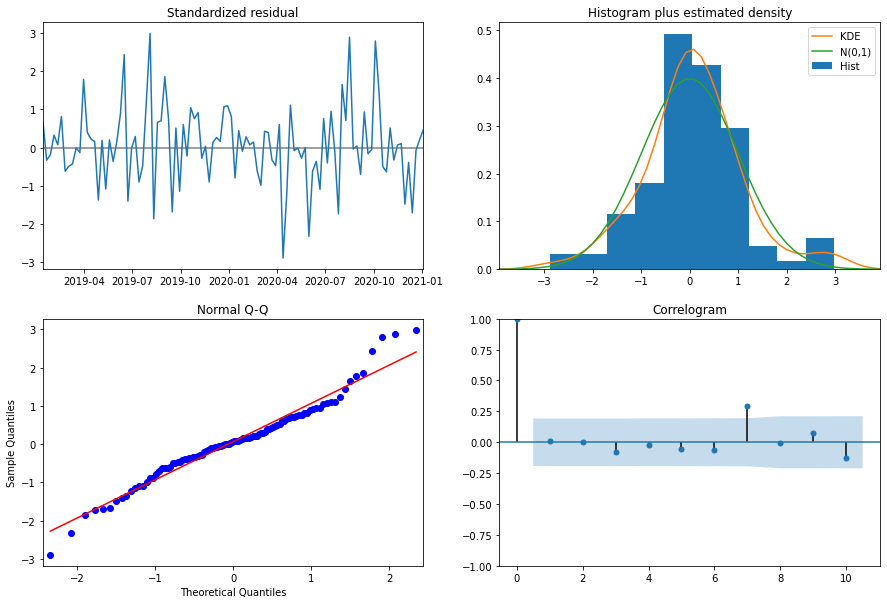

In [47]:
bm_sarimax_t.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

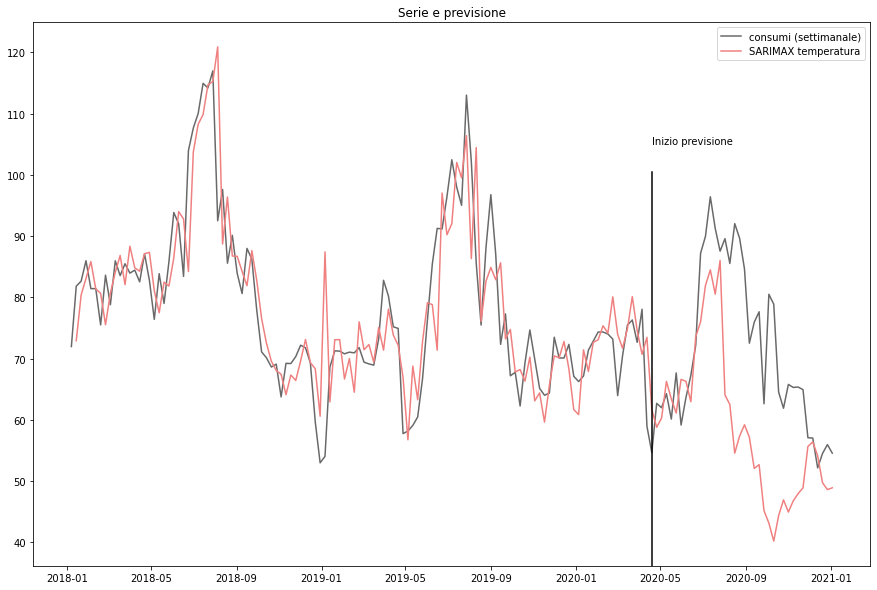

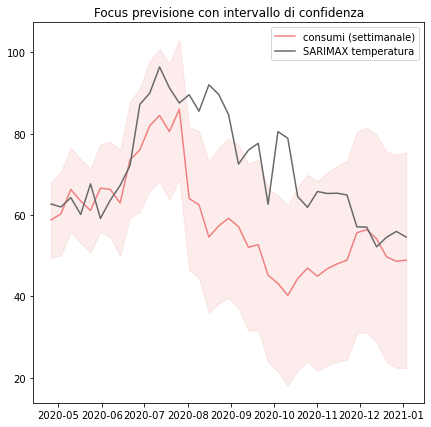

In [48]:
sarimax_t120 = forecast(36, bm_sarimax_t120, "SARIMAX temperatura", "lightcoral", exog=exog_t[:120])

Previsione a 3 mesi

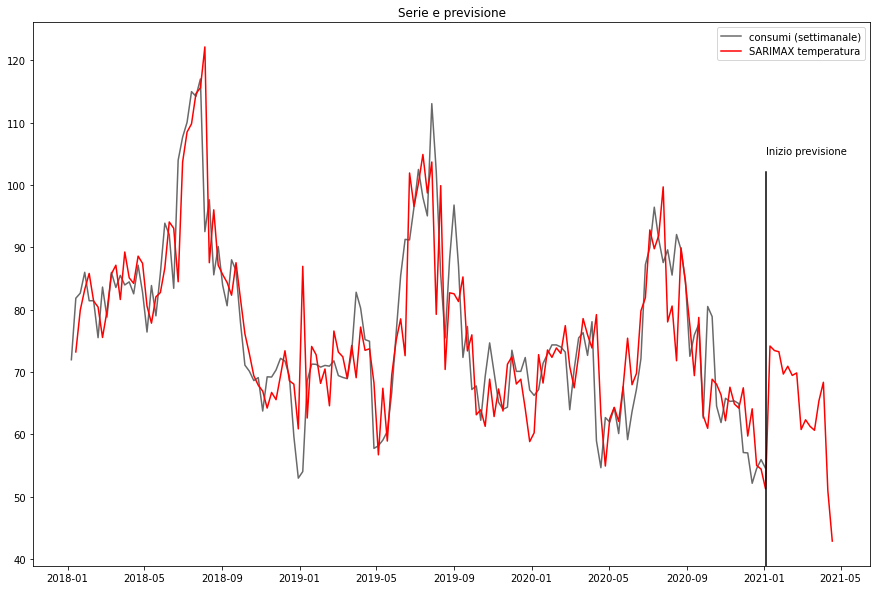

In [49]:
sarimax_t = forecast(14, bm_sarimax_t, "SARIMAX temperatura", "red", exog=exog_t)

Previsione a 6 mesi

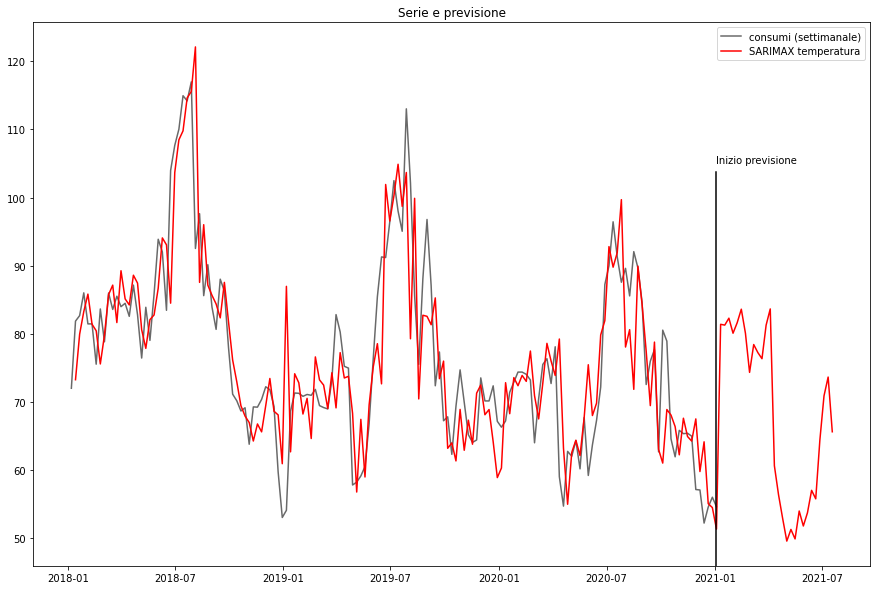

In [50]:
sarimax_t = forecast(27, bm_sarimax_t, "SARIMAX temperatura", "red", exog=exog_t)

Previsione a 9 mesi

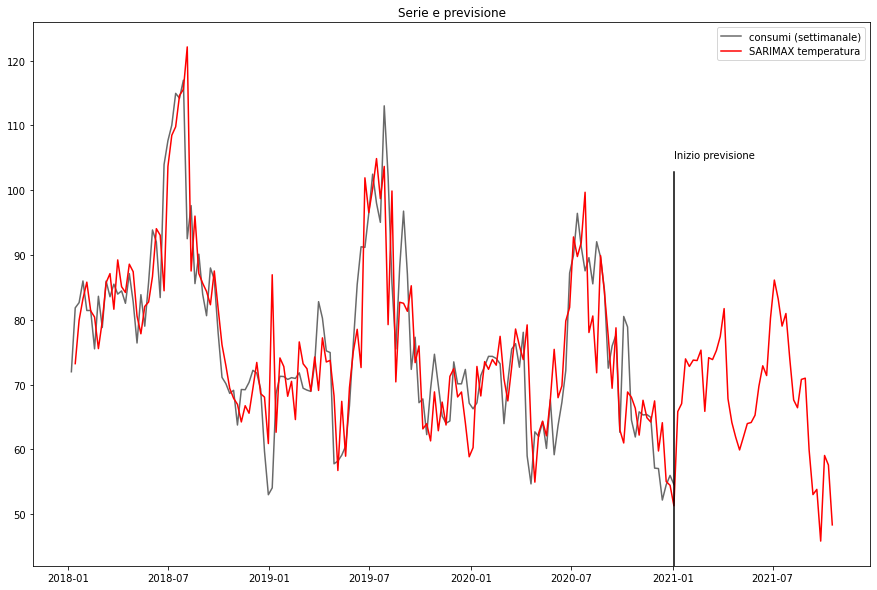

In [51]:
sarimax_t = forecast(40, bm_sarimax_t, "SARIMAX temperatura", "red", exog=exog_t)

### Verifica bontà del modello previsionale 

MAPE overall (157 osservazioni)

In [52]:
mape(endog, sarimax_t)

'MAPE: 7.61%'

MAPE training set (first 120 osservazioni)

In [53]:
mape(endog, sarimax_t120, 120)

'MAPE: 7.46%'

MAPE test set (last 37 osservazioni)

In [54]:
mape(endog, sarimax_t120, -37)

'MAPE: 18.29%'

## SARIMAX umidità:
    endog = consumi
    exog_h = humidity

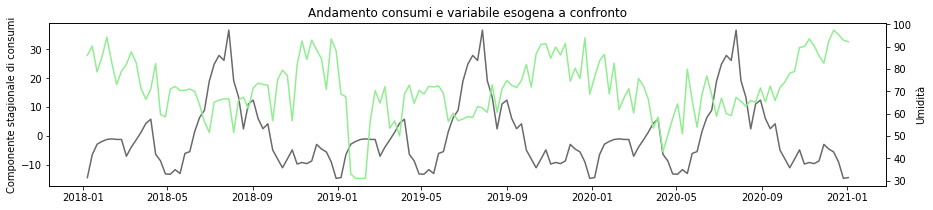

In [55]:
plot_exog(exog_h, "Umidità", "lightgreen")

### Best model

In [56]:
best_param_sarimax_h120 = optimize_SARIMAX(parameters_list, d, D, s, endog[:120], exog_h[:120])
best_param_sarimax_h120[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 1, 0)  467.200395
1  (0, 2, 0, 1)  467.240377
2  (2, 1, 1, 0)  467.847233
3  (2, 1, 0, 1)  467.915789
4  (0, 2, 0, 0)  467.943309

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [57]:
bm_sarimax_h120 = SARIMAX(endog[:120],
                     exog_h[:120],
                     order=(0,1,2), # p d q
                     seasonal_order=(1,1,0,52), # P D Q s
                     simple_differencing=False).fit(disp=False)

bm_sarimax_h120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -228.600
Date:                             Thu, 11 Nov 2021   AIC                            467.200
Time:                                     15:57:11   BIC                            478.224
Sample:                                 01-07-2018   HQIC                           471.562
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity       0.0207      0.069      0.298      0.766      -0.115       0.157
ma.L1         -0.3939      0.119     -3.315      0.001      -0.627      -0.161
ma.L2         -0.3780      0.120     -3.138      0.002      -0.614      -0.142
ar.S.L52      -0.5444      0.221     -2.463      0.014      -0.978      -0.111
sigma2        40.4857     12.921      3.133      0.002      15.161      65.810
===================================================================================
Ljung-Box (Q):                       54.75   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.06   Prob(JB):                         0.91
Heteroskedasticity (H):               1.45   Skew:                            -0.10
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

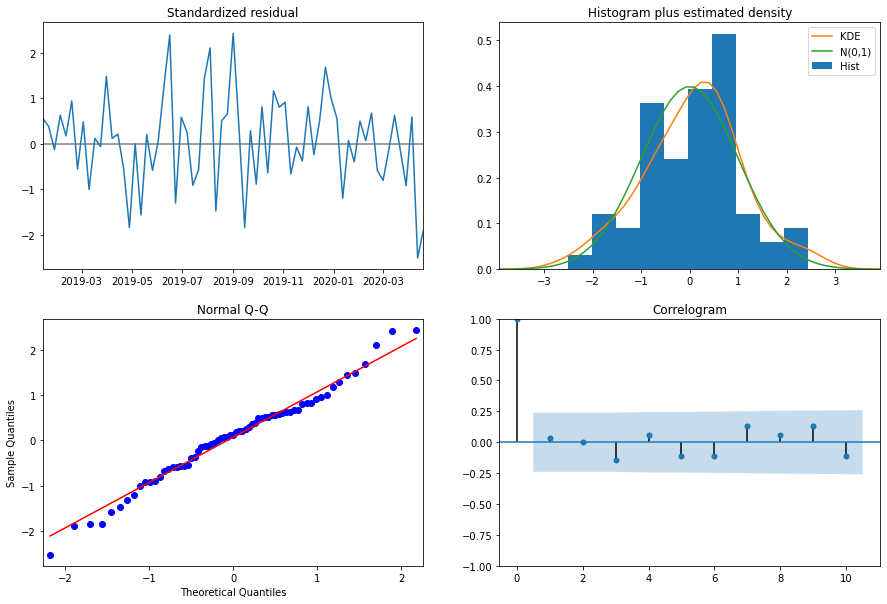

In [58]:
bm_sarimax_h120.plot_diagnostics();

In [59]:
best_param_sarimax_h = optimize_SARIMAX(parameters_list, d, D, s, endog, exog_h)
best_param_sarimax_h[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 0, 1)  730.101347
1  (0, 2, 1, 0)  730.126023
2  (2, 2, 1, 0)  730.664337
3  (2, 2, 0, 1)  730.668243
4  (2, 1, 0, 1)  730.792168

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

Abbiamo scelto di utilizzare il secondo migliore AIC per avere gli stessi parametri del modello SARIMA_h120 precedente, infatti la differenza tra i primi due risultati in questo secondo modello è irrisoria.

In [60]:
bm_sarimax_h = SARIMAX(endog,
                     exog_h,
                     order=(0,1,2), # p d q
                     seasonal_order=(1,1,0,52), # P D Q s
                     simple_differencing=False).fit(disp=False) 

bm_sarimax_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -360.063
Date:                             Thu, 11 Nov 2021   AIC                            730.126
Time:                                     16:02:00   BIC                            743.348
Sample:                                 01-07-2018   HQIC                           735.483
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.0201      0.072     -0.278      0.781      -0.162       0.122
ma.L1         -0.3951      0.110     -3.601      0.000      -0.610      -0.180
ma.L2         -0.3704      0.118     -3.131      0.002      -0.602      -0.139
ar.S.L52      -0.4636      0.118     -3.940      0.000      -0.694      -0.233
sigma2        52.3430      6.402      8.176      0.000      39.795      64.891
===================================================================================
Ljung-Box (Q):                       43.05   Jarque-Bera (JB):                 5.20
Prob(Q):                              0.34   Prob(JB):                         0.07
Heteroskedasticity (H):               1.40   Skew:                             0.27
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

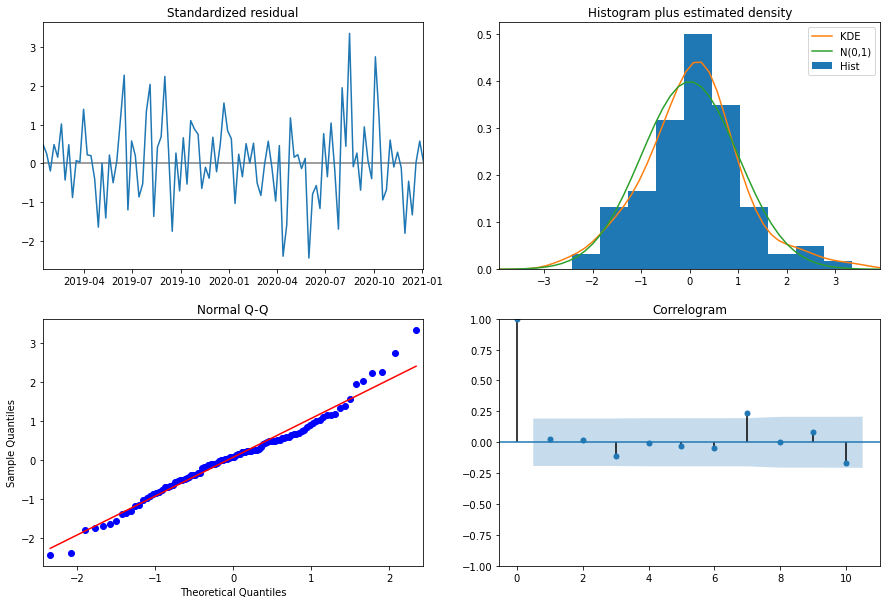

In [61]:
bm_sarimax_h.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

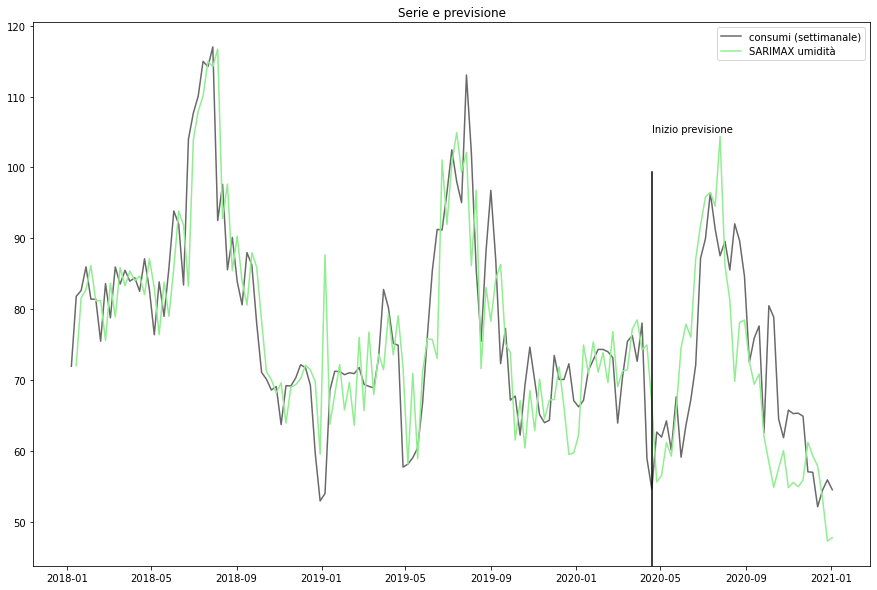

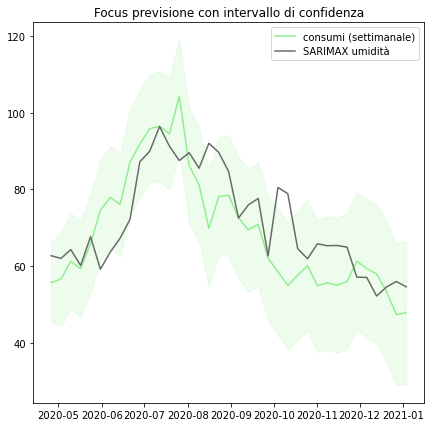

In [62]:
sarimax_h120 = forecast(36, bm_sarimax_h120, "SARIMAX umidità", "lightgreen", exog=exog_h[:120])

Previsione a 3 mesi

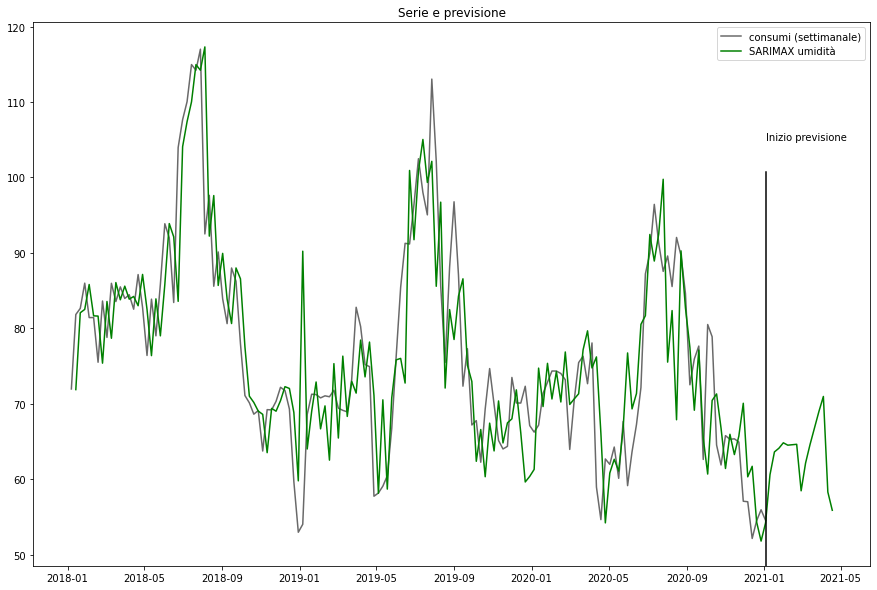

In [63]:
sarimax_h = forecast(14, bm_sarimax_h, "SARIMAX umidità", "green", exog=exog_h)

Previsione a 6 mesi

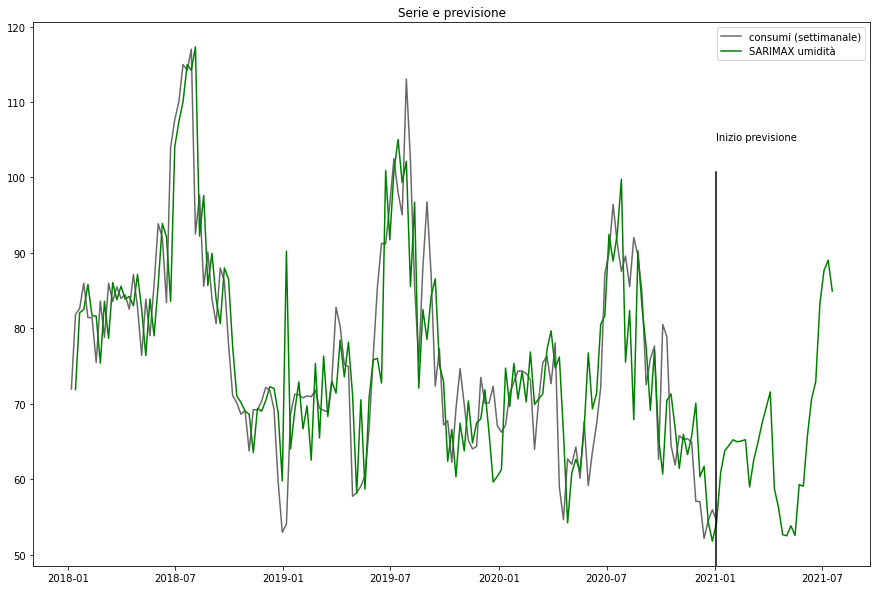

In [64]:
sarimax_h = forecast(27, bm_sarimax_h, "SARIMAX umidità", "green", exog=exog_h)

Previsione a 9 mesi

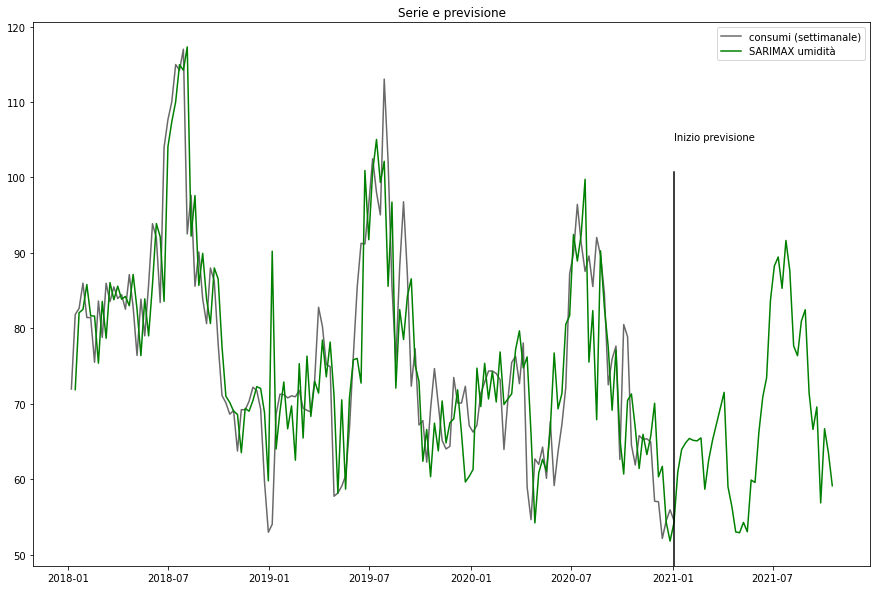

In [65]:
sarimax_h = forecast(40, bm_sarimax_h, "SARIMAX umidità", "green", exog=exog_h)

### Verifica bontà del modello previsionale 

MAPE overall (157 osservazioni)

In [66]:
mape(endog, sarimax_h)

'MAPE: 8.24%'

MAPE training set (prime 120 osservazioni)

In [67]:
mape(endog, sarimax_h120, 120)

'MAPE: 8.26%'

MAPE test set (ultime 37 osservazioni)

In [68]:
mape(endog, sarimax_h120, -37)

'MAPE: 10.87%'

## SARIMAX pioggia: 
    endog = consumi
    exog_r = is_raining

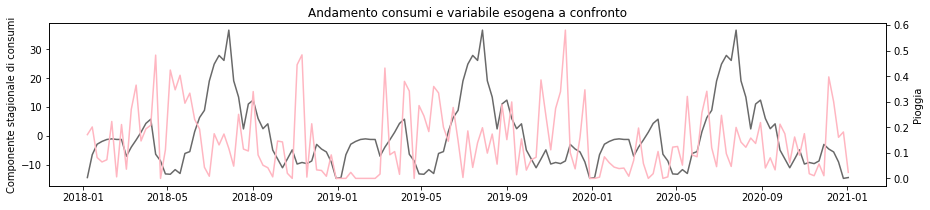

In [69]:
plot_exog(exog_r, "Pioggia", "lightpink")

### Best model

In [70]:
best_param_sarimax_r120 = optimize_SARIMAX(parameters_list, d, D, s, endog[:120], exog_r[:120])
best_param_sarimax_r120[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 1, 0)  467.102674
1  (0, 2, 0, 1)  467.152974
2  (2, 1, 1, 0)  467.717151
3  (2, 1, 0, 1)  467.805485
4  (0, 2, 0, 0)  467.974311

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [71]:
bm_sarimax_r120 = SARIMAX(endog[:120],
                     exog_r[:120],
                     order=(0,1,2), # p d q
                     seasonal_order=(1,1,0,52), # P D Q s
                     simple_differencing=False).fit(disp=False)

bm_sarimax_r120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -228.551
Date:                             Thu, 11 Nov 2021   AIC                            467.103
Time:                                     16:05:25   BIC                            478.126
Sample:                                 01-07-2018   HQIC                           471.465
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_raining     2.3651      5.338      0.443      0.658      -8.096      12.826
ma.L1         -0.3912      0.133     -2.945      0.003      -0.651      -0.131
ma.L2         -0.3828      0.116     -3.298      0.001      -0.610      -0.155
ar.S.L52      -0.5486      0.216     -2.540      0.011      -0.972      -0.125
sigma2        40.2173     12.415      3.239      0.001      15.884      64.550
===================================================================================
Ljung-Box (Q):                       55.84   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.05   Prob(JB):                         0.89
Heteroskedasticity (H):               1.49   Skew:                            -0.09
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

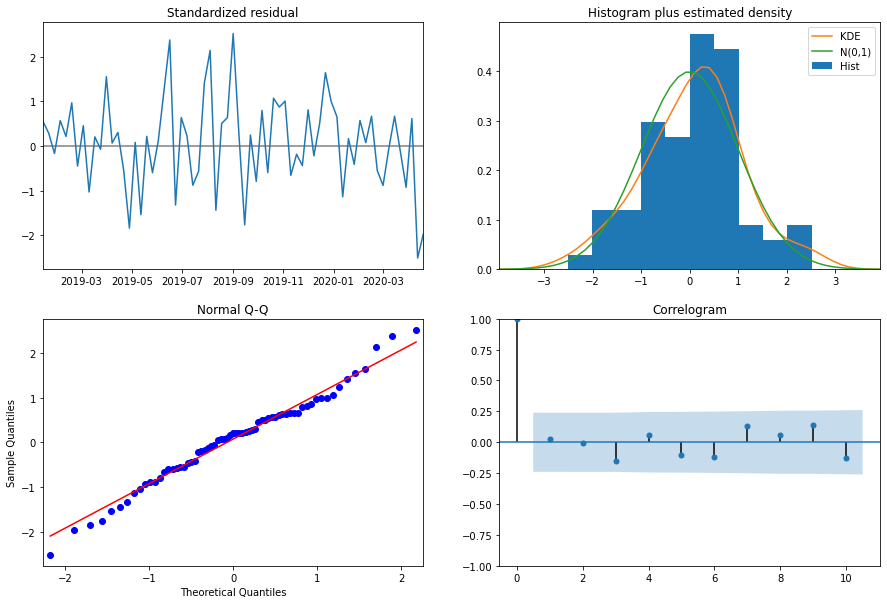

In [72]:
bm_sarimax_r120.plot_diagnostics();

Abbiamo scelto di utilizzare il secondo migliore AIC per avere gli stessi parametri del modello SARIMA_r120 precedente, infatti la differenza tra i primi due risultati in questo secondo modello è irrisoria.

In [73]:
best_param_sarimax_r = optimize_SARIMAX(parameters_list, d, D, s, endog, exog_r)
best_param_sarimax_r[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 0, 1)  730.162577
1  (0, 2, 1, 0)  730.189793
2  (2, 2, 0, 1)  730.517174
3  (2, 2, 1, 0)  730.521420
4  (2, 1, 0, 1)  730.832953

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [74]:
bm_sarimax_r = SARIMAX(endog,
                     exog_r,
                     order=(0,1,2), #p d q
                     seasonal_order=(1,1,0,52), #P D Q s
                     simple_differencing=False).fit(disp=False)

bm_sarimax_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -360.095
Date:                             Thu, 11 Nov 2021   AIC                            730.190
Time:                                     16:10:03   BIC                            743.412
Sample:                                 01-07-2018   HQIC                           735.546
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_raining    -0.9176      5.384     -0.170      0.865     -11.470       9.635
ma.L1         -0.3981      0.115     -3.463      0.001      -0.623      -0.173
ma.L2         -0.3666      0.118     -3.094      0.002      -0.599      -0.134
ar.S.L52      -0.4681      0.117     -3.992      0.000      -0.698      -0.238
sigma2        52.2350      6.195      8.432      0.000      40.093      64.377
===================================================================================
Ljung-Box (Q):                       42.76   Jarque-Bera (JB):                 4.96
Prob(Q):                              0.35   Prob(JB):                         0.08
Heteroskedasticity (H):               1.41   Skew:                             0.27
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

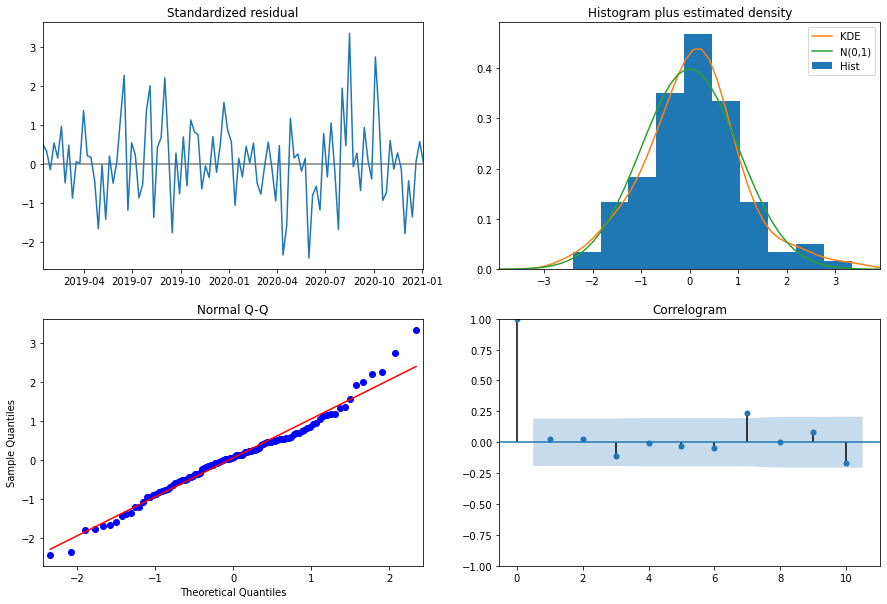

In [75]:
bm_sarimax_r.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

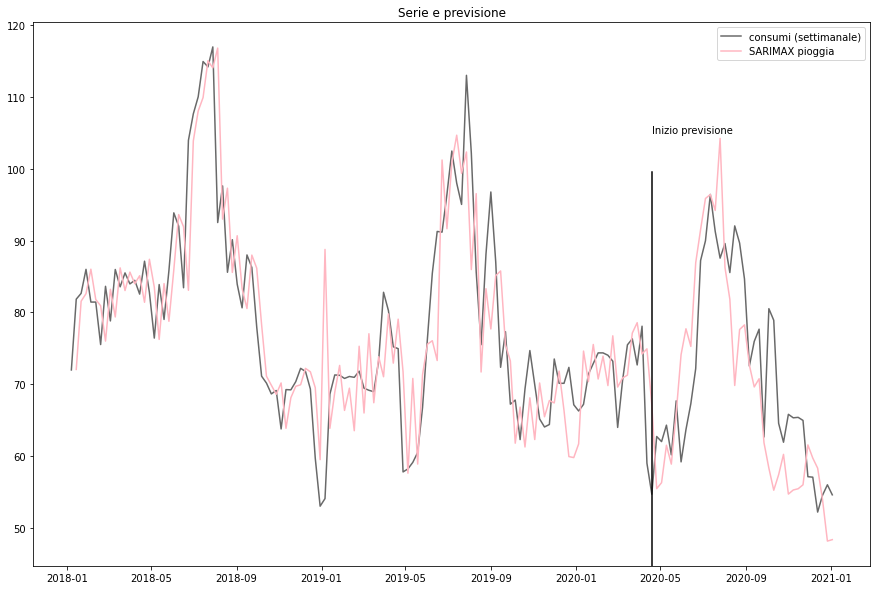

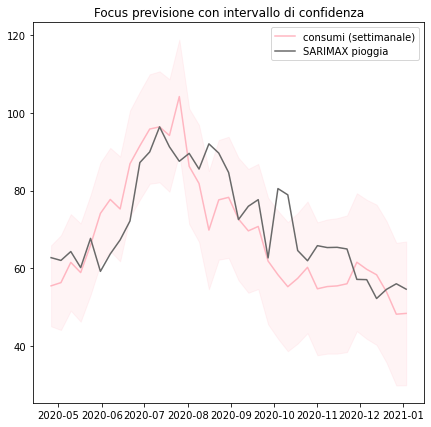

In [76]:
sarimax_r120 = forecast(36, bm_sarimax_r120, "SARIMAX pioggia", "lightpink", exog=exog_r[:120])

Previsione a 3 mesi

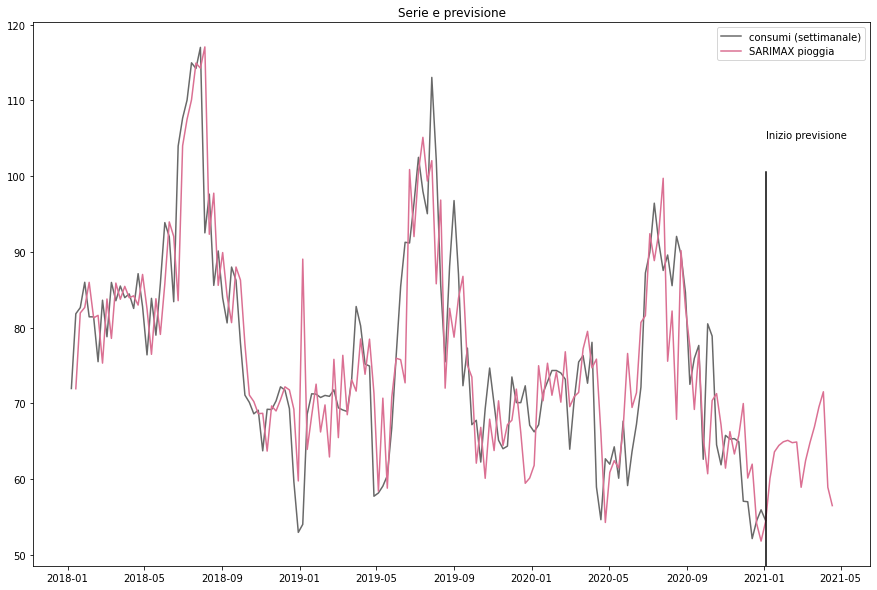

In [77]:
sarimax_r = forecast(14, bm_sarimax_r, "SARIMAX pioggia", "palevioletred", exog=exog_r) 

Previsione a 6 mesi

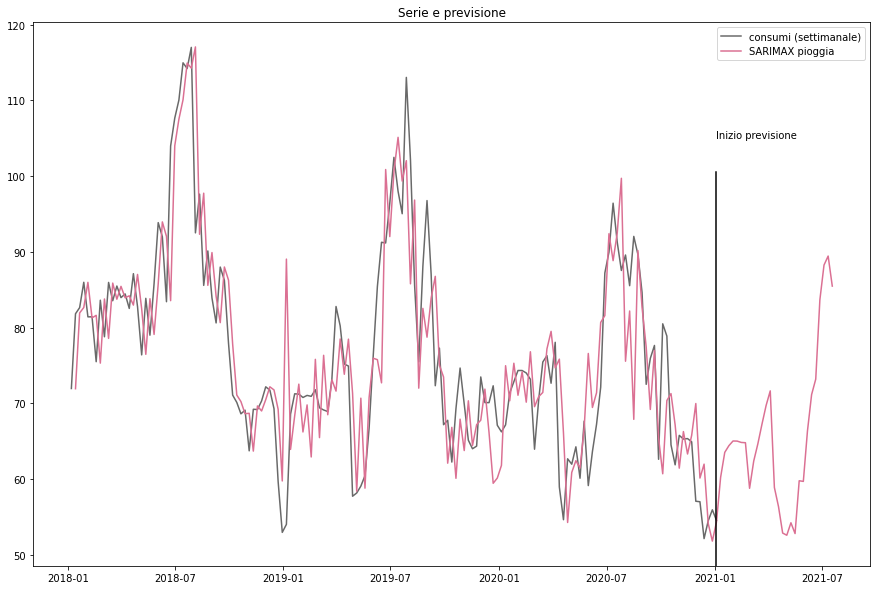

In [78]:
sarimax_r = forecast(27, bm_sarimax_r, "SARIMAX pioggia", "palevioletred", exog=exog_r) 

Previsione a 9 mesi

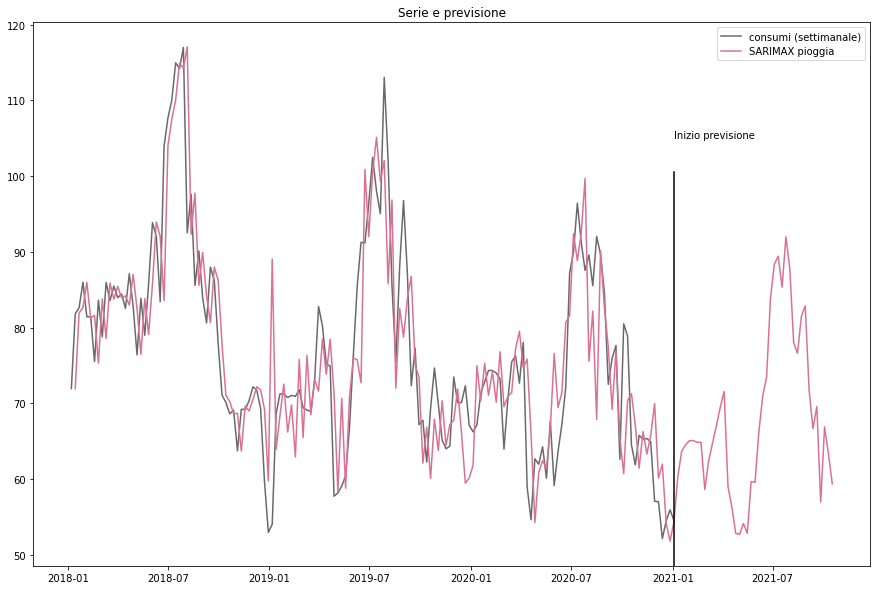

In [79]:
sarimax_r = forecast(40, bm_sarimax_r, "SARIMAX pioggia", "palevioletred", exog=exog_r) 

### Verifica bontà del modello previsionale 

MAPE overall (157 osservazioni)

In [80]:
mape(endog, sarimax_r)

'MAPE: 8.24%'

MAPE training set (prime 120 osservazioni)

In [81]:
mape(endog, sarimax_r120, 120)

'MAPE: 8.32%'

MAPE test set (ultime 37 osservazioni)

In [82]:
mape(endog, sarimax_r120, -37)

'MAPE: 10.78%'

## SARIMAX ore di luce:
    endog = consumi
    exog_l = ore_luce

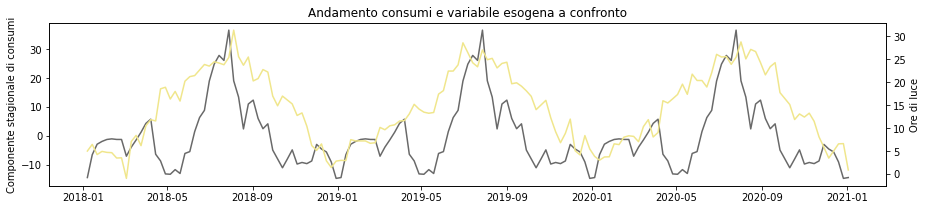

In [83]:
plot_exog(exog_t, "Ore di luce", "khaki")

### Best model

In [84]:
best_param_sarimax_l120 = optimize_SARIMAX(parameters_list, d, D, s, endog[:120], exog_l[:120])
best_param_sarimax_l120[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 1, 0)  467.211452
1  (0, 2, 0, 1)  467.213724
2  (0, 2, 0, 0)  467.380151
3  (2, 1, 0, 1)  467.852917
4  (1, 1, 0, 0)  468.522591

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [85]:
bm_sarimax_l120 = SARIMAX(endog[:120],
                     exog_l[:120],
                     order=(0,1,2), # p d q 
                     seasonal_order=(1,1,0,52), # P D Q s
                     simple_differencing=False).fit(disp=False)

bm_sarimax_l120.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -228.606
Date:                             Thu, 11 Nov 2021   AIC                            467.211
Time:                                     16:13:20   BIC                            478.235
Sample:                                 01-07-2018   HQIC                           471.573
                                      - 04-19-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ore_luce      -1.0883      4.502     -0.242      0.809      -9.911       7.735
ma.L1         -0.3911      0.117     -3.339      0.001      -0.621      -0.161
ma.L2         -0.3699      0.130     -2.856      0.004      -0.624      -0.116
ar.S.L52      -0.5117      0.249     -2.052      0.040      -1.000      -0.023
sigma2        42.0574     12.453      3.377      0.001      17.650      66.464
===================================================================================
Ljung-Box (Q):                       54.82   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.06   Prob(JB):                         0.90
Heteroskedasticity (H):               1.55   Skew:                            -0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

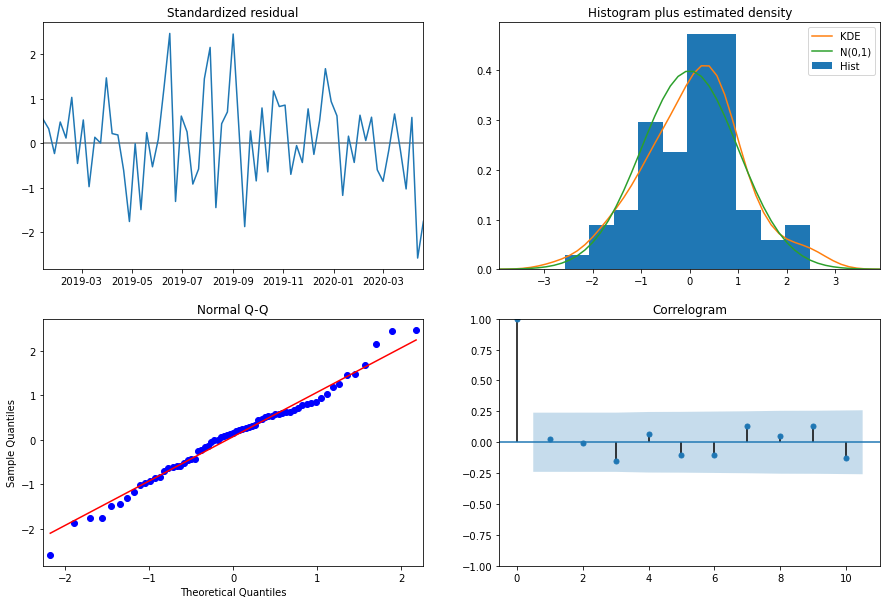

In [86]:
bm_sarimax_l120.plot_diagnostics();

In [87]:
best_param_sarimax_l = optimize_SARIMAX(parameters_list, d, D, s, endog, exog_l)
best_param_sarimax_l[:5]

(p,q)x(P,Q)         AIC
0  (0, 2, 0, 1)  730.188213
1  (0, 2, 1, 0)  730.215341
2  (2, 2, 0, 1)  730.501663
3  (2, 2, 1, 0)  730.570987
4  (2, 1, 0, 1)  730.836463

Abbiamo scelto di utilizzare il secondo migliore AIC per avere gli stessi parametri del modello SARIMA_r120 precedente, infatti la differenza tra i primi due risultati in questo secondo modello è irrisoria.

p = 0 d = 1 q = 2 P = 1 D = 1 Q = 0 s = 52

In [88]:
bm_sarimax_l = SARIMAX(endog,
                     exog_l,
                     order=(0,1,2), # p d q
                     seasonal_order=(1,1,0,52), # P D Q s
                     simple_differencing=False).fit(disp=False)

bm_sarimax_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumi   No. Observations:                  157
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 52)   Log Likelihood                -360.108
Date:                             Thu, 11 Nov 2021   AIC                            730.215
Time:                                     16:18:20   BIC                            743.437
Sample:                                 01-07-2018   HQIC                           735.572
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ore_luce      -0.3565      4.005     -0.089      0.929      -8.206       7.493
ma.L1         -0.3961      0.109     -3.644      0.000      -0.609      -0.183
ma.L2         -0.3692      0.119     -3.102      0.002      -0.602      -0.136
ar.S.L52      -0.4648      0.118     -3.937      0.000      -0.696      -0.233
sigma2        52.3517      6.154      8.506      0.000      40.289      64.414
===================================================================================
Ljung-Box (Q):                       42.83   Jarque-Bera (JB):                 4.72
Prob(Q):                              0.35   Prob(JB):                         0.09
Heteroskedasticity (H):               1.41   Skew:                             0.27
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

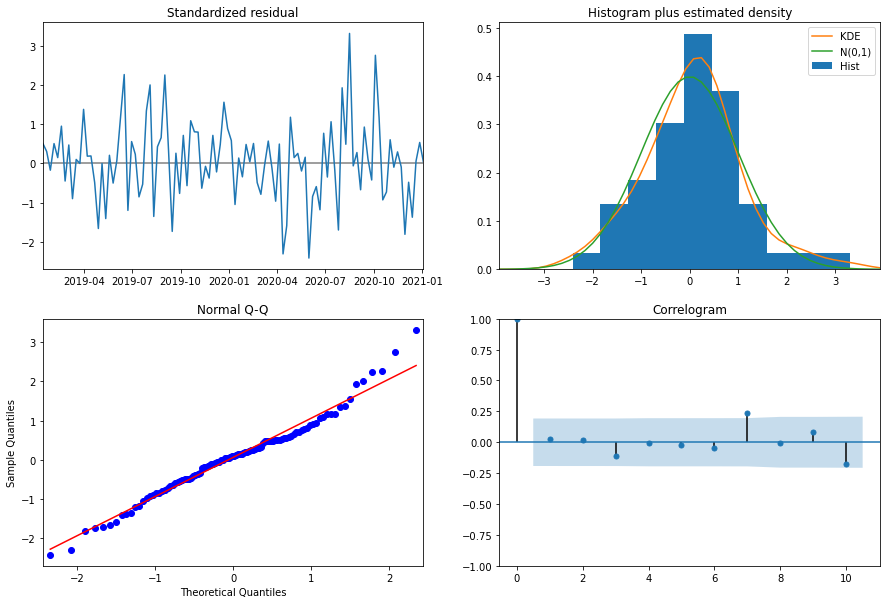

In [89]:
bm_sarimax_l.plot_diagnostics();

### Previsione e intervallo di confidenza al 10% della previsione

Previsione training-test

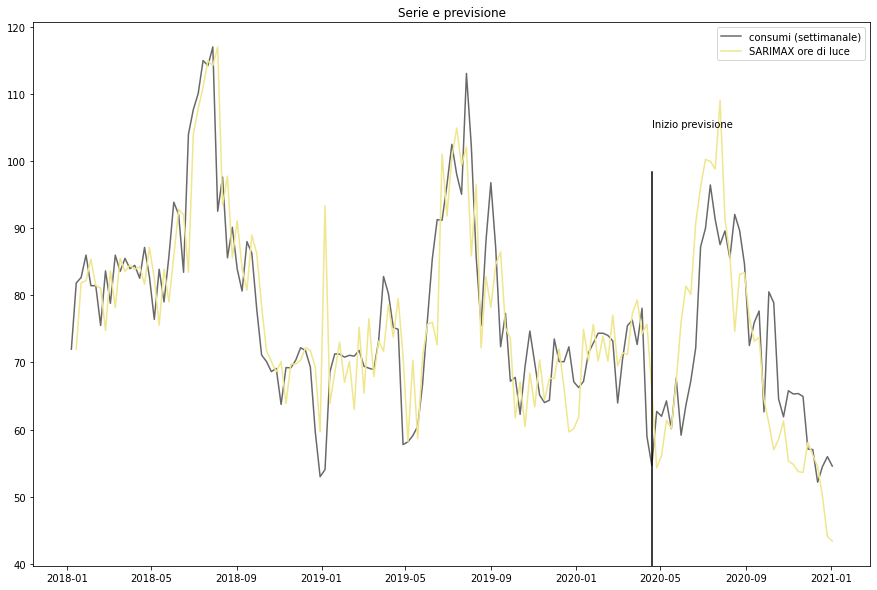

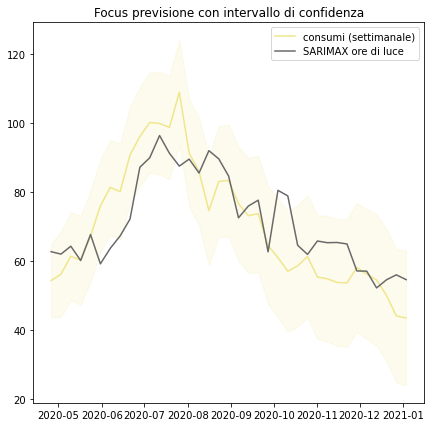

In [90]:
sarimax_l120 = forecast(36, bm_sarimax_l120, "SARIMAX ore di luce", "khaki", exog=exog_l[:120])

Previsione a 3 mesi

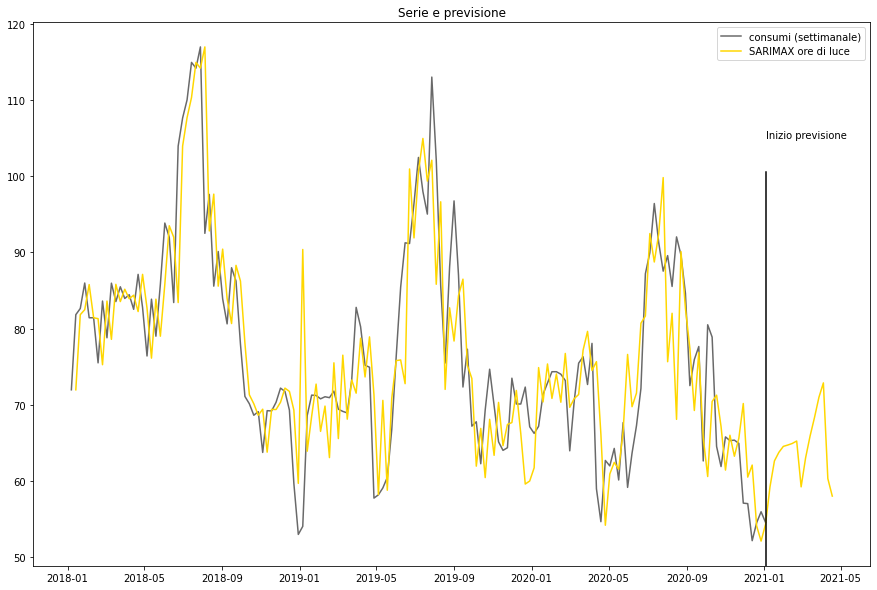

In [91]:
sarimax_l = forecast(14, bm_sarimax_l, "SARIMAX ore di luce", "gold", exog=exog_l) 

Previsione a 6 mesi

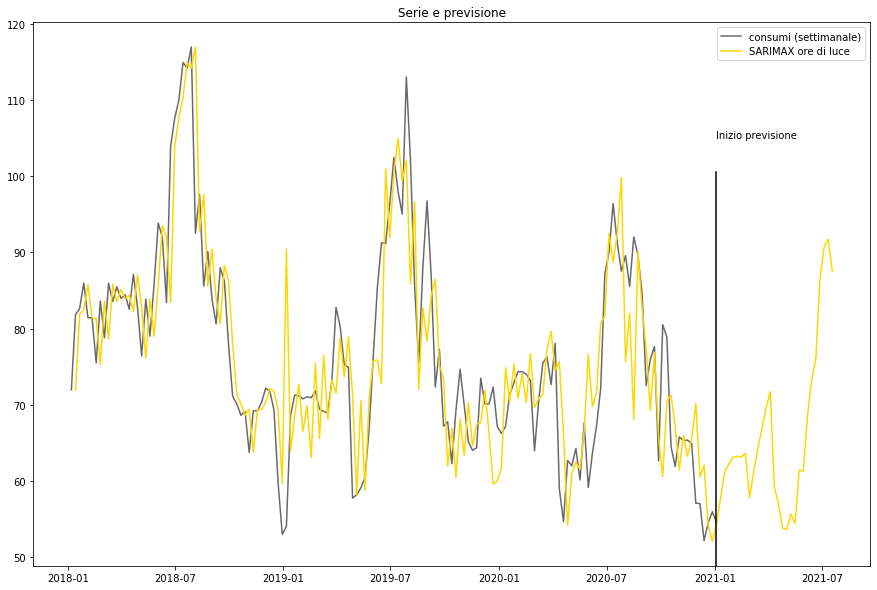

In [92]:
sarimax_l = forecast(27, bm_sarimax_l, "SARIMAX ore di luce", "gold", exog=exog_l) 

Previsione a 9 mesi

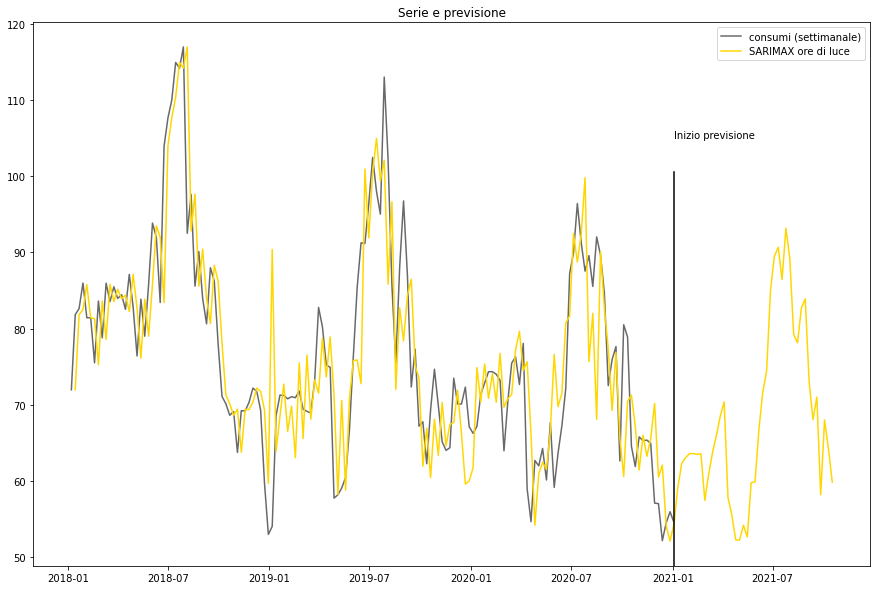

In [93]:
sarimax_l = forecast(40, bm_sarimax_l, "SARIMAX ore di luce", "gold", exog=exog_l) 

### Verifica bontà del modello previsionale 

MAPE overall (157 osservazioni)

In [94]:
mape(endog, sarimax_l)

'MAPE: 8.3%'

MAPE training set (prime 120 osservazioni)

In [95]:
mape(endog, sarimax_l120, 120)

'MAPE: 8.47%'

MAPE test set (ultime 37 osservazioni)

In [96]:
mape(endog, sarimax_l120, -37)

'MAPE: 11.41%'